# WRUV Broadcasting Dataset Project
Authors: Sydney White and Zachary Hayes

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import time 

## Data Collection, Cleaning, and Feature Engineering
#### Initial Collection and Cleaning


In [22]:
# Collect data CSVs into a single dataframe
dfs = []
directory = "dataset" 
for file in os.listdir(directory):
    df = pd.read_csv(f'{directory}/{file}')
    dfs.append(pd.read_csv(f'{directory}/{file}'))
df = pd.concat(dfs, axis=0)
df.sort_values("Date-time", inplace=True, ignore_index=True)
# Drop columns that we already know we don't need
df.drop(["Playlist Category", "Playlist Duration", "DJ Email", "Date-time", "Composer"], axis=1, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df

,Playlist Title,DJ ID,DJ Name,Date,Time,Artist,Song,Release,New,Local,Genre,Label,UPC
0,Our Intent is All for Your Delight,64617,Dan Kirk,2019-09-23,8:04:12 AM,Khruangbin,People Everywhere (Still Alive),The Universe Smiles Upon You,NaN,NaN,Rock,Night Time Stories,4523132552217.0
1,Our Intent is All for Your Delight,64617,Dan Kirk,2019-09-23,8:07:21 AM,The Bubs,Golden Thread,Golden Thread,NaN,NaN,Rock,The Bubs,859732310242.0
2,Our Intent is All for Your Delight,64617,Dan Kirk,2019-09-23,8:11:38 AM,Y La Bamba,Rios Sueltos,Entre Los Dos,N,NaN,Rock,Tender Loving Empire,703669152959.0
3,Our Intent is All for Your Delight,64617,Dan Kirk,2019-09-23,8:15:42 AM,Allah-Las,Prazer Em Te Conhecer,LAHS,NaN,NaN,Rock,Mexican Summer,184923126068.0
4,Our Intent is All for Your Delight,64617,Dan Kirk,2019-09-23,8:20:57 AM,Devendra Banhart,My Boyfriend's in the Band,Ma,NaN,NaN,Rock,Nonesuch,75597924053.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284735,Long Distance Runner,160029,DJ Squared,2024-03-22,4:05:08 PM,Bill Laswell,Buhala,Means of Deliverance,NaN,NaN,Jazz,Innerhythmic,0804699102423
284736,Long Distance Runner,160029,DJ Squared,2024-03-22,4:08:25 PM,Remy Le Boeuf,Little Song,Heartland Radio,NaN,NaN,Jazz,ORCHARD - SoundSpore Records,0197190669947
284737,Long Distance Runner,160029,DJ Squared,2024-03-22,4:14:10 PM,strongboi,fool around,fool around,NaN,NaN,NaN,strongboi,5059449065564
284738,Long Distance Runner,160029,DJ Squared,2024-03-22,4:18:52 PM,Miya Folick,Bad Thing,Bad Thing,NaN,NaN,NaN,Nettwerk Music Group,0067003373463


In [23]:
# Count null values
df.isna().sum()

Playlist Title         0
DJ ID                  0
DJ Name                0
Date                   0
Time                   0
Artist                 4
Song                   2
Release               50
New               252062
Local             281156
Genre              97305
Label               1137
UPC                28232
dtype: int64

In [24]:
# Clean the null values from the boolean columns New and Local
df["New"] = df["New"].map({"N": 1, np.nan: 0})
df["Local"] = df["Local"].map({"L": 1, np.nan: 0})

# Since there are only 56 instances where artist, song, or release are null,
# we feel comfortable dropping those instances
df = df.dropna(subset=["Artist", "Song", "Release"])

# Count null values again
df.isna().sum()


Playlist Title        0
DJ ID                 0
DJ Name               0
Date                  0
Time                  0
Artist                0
Song                  0
Release               0
New                   0
Local                 0
Genre             97305
Label              1095
UPC               28182
dtype: int64

In [61]:
# Define smaller data set for linear regression (for now)
lr = df[df["Date"] > "2024-01-01"]
len(lr)

month = df[df["Date"] > "2024-03-01"]
month

,Playlist Title,DJ ID,DJ Name,Date,Time,Artist,Song,Release,New,Local,Genre,Label,UPC
278424,Noise by People,176440,Babytooth,2024-03-02,12:08:12 AM,Con Dolore,The 7th,This Sad Movie,0,0,Rock,Clairecords,808804002424
278425,Noise by People,176440,Babytooth,2024-03-02,12:11:39 AM,You'll Never Get to Heaven,Dust,Wave Your Moonlight Hat For the Snowfall Train,0,0,Rock,Mystic Roses,NaN
278426,Noise by People,176440,Babytooth,2024-03-02,12:25:36 AM,Jessica Pratt,On Your Own Love Again,On Your Own Love Again,0,0,Rock,Drag City Records,781484060628
278427,Noise by People,176440,Babytooth,2024-03-02,12:27:23 AM,Grouper,Blouse,Grid of Points,0,0,Electronic,kranky,796441821723
278428,Noise by People,176440,Babytooth,2024-03-02,12:28:59 AM,Emma Anderson,The Presence,Pearlies,1,0,Rock,Sonic Cathedral,5056321690814
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284735,Long Distance Runner,160029,DJ Squared,2024-03-22,4:05:08 PM,Bill Laswell,Buhala,Means of Deliverance,0,0,Jazz,Innerhythmic,0804699102423
284736,Long Distance Runner,160029,DJ Squared,2024-03-22,4:08:25 PM,Remy Le Boeuf,Little Song,Heartland Radio,0,0,Jazz,ORCHARD - SoundSpore Records,0197190669947
284737,Long Distance Runner,160029,DJ Squared,2024-03-22,4:14:10 PM,strongboi,fool around,fool around,0,0,NaN,strongboi,5059449065564
284738,Long Distance Runner,160029,DJ Squared,2024-03-22,4:18:52 PM,Miya Folick,Bad Thing,Bad Thing,0,0,NaN,Nettwerk Music Group,0067003373463


#### Additional Collection: Filling Missing Genres and Spotify Audio Features

In [62]:
# global variable for valid genres in spinitron 
GENRES = df['Genre'].unique().tolist()
for g in range(len(GENRES)):
    GENRES[g] = (str(GENRES[g])).lower()
    
# function to interface with Spotify Web API app (created with id and secret below) STILL WIP!
def spotify_connect():
    # technically insecure to have client secret displayed like this (environment variable)
    CLIENT_ID = '344d3b062e344710a5bdb8427358a31d'
    CLIENT_SECRET = '9f886dde51184f989b1aff4f5ffb21f8'
    AUTH_URL = 'https://accounts.spotify.com/api/token'

    auth_manager = SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        requests_session=True)

    sp = spotipy.Spotify(auth_manager=auth_manager)
    # this is our connection which we will need for any future query 
    return sp
    
# just making this global for effeciency (no need to reaccess every time) 
sp = spotify_connect()

def get_genre_by_artist(artist_name):
    # spotify queries are all based on Spotify URI IDs and usually return in JSON
    results = sp.search(q='artist:' + artist_name, type='artist', limit=10)
    # make sure that the result is for the artist we want
    try: 
        result_name = results['artists']['items'][0]['name']
    except IndexError:
        result_name = ''
        return 'NA'
    i = 0
    while (result_name != artist_name) & (i < 10) & (i < len(results)):
        result_name = results['artists']['items'][i]['name']
        i += 1
    if (result_name == artist_name):
        genres = results['artists']['items'][i]['genres'] # for top result (in this case accurate, but probably not always)
        id = results['artists']['items'][i]['id']
        for genre in genres:
            if genre in GENRES:
                return genre 
    return 'NA'


# TODO: how to run this only to fill in if Genre is NA
#df['Genre'] = df['Artist'].apply(lambda x: get_genre_by_artist(x) if pd.isnull(df['Genre']) else x)

# next step: instead of returning result_string, return dictionary of values OR empty dictionary of NAs?
def spotify_search_song(artist_name, song_name):
    results = sp.search(q='track:' + song_name, type='track', limit=10)
    results_title = results['tracks']['items'][0]['name']
    results_album = results['tracks']['items'][0]['album']['name']
    results_artist = results['tracks']['items'][0]['artists'][0]['name']
    # if this results title matches our song name and the artist matches our artist, find the audio features and add them (by spotify uri id for song)
    i = 0
    while (results_artist != artist_name) & (results_title != song_name) & (i < 10):
        results_title = results['tracks']['items'][i]['name']
        results_artist = results['tracks']['items'][i]['artists'][0]['name']
        i += 1
    if (results_artist == artist_name) & (results_title == song_name):
        uri = results['tracks']['items'][i]['id'] 
        # these are audio features!! like danceability, energy, key, loudness..
        # stored in an array of length 1 containing a dictionary (key = audio feature, value = value of that feature)
        features = sp.audio_features(uri)
        result_string =  f'TOP RESULT: {results_title} from {results_album} by {results_artist}. URI: {uri}'
        return features[0]
    return {}

print(len(lr))
print(lr["Genre"].isna().sum())

lr.loc[lr["Genre"].isna(), "Genre"] = lr.loc[lr["Genre"].isna()].apply(get_genre_by_artist)

print(lr["Genre"].isna().sum())
#lr["Genre"] = lr["Genre"].astype('str')
#print((lr["Genre"].iloc[5]))

#df.loc[df['area'].isna(), 'Area'] = df.loc[df['area'].isna()].apply(lambda x: sample_func(x['Val']), axis = 1)

#smaller['Genre'] = df['Artist'].apply(lambda x: get_genre_by_artist(x) if pd.isnull(df['Genre']) else x)
#smaller['songAudio'] = smaller.apply(lambda row: spotify_search_song(row['Artist'], row['Song']), axis=1)
#lr["Genre"].isna()
#smaller

25804
10362


HTTP Error for GET to https://api.spotify.com/v1/search with Params: {'q': 258933    artist:WRUV 1/2/24, 12:05 AM
258934    artist:WRUV 1/2/24, 12:05 AM
258935    artist:WRUV 1/2/24, 12:05 AM
258936    artist:WRUV 1/2/24, 12:05 AM
258938    artist:WRUV 1/2/24, 12:05 AM
                      ...             
284729     artist:tunez from the crypt
284730     artist:tunez from the crypt
284733     artist:Long Distance Runner
284737     artist:Long Distance Runner
284738     artist:Long Distance Runner
Name: Playlist Title, Length: 10362, dtype: object, 'limit': 10, 'offset': 0, 'type': 'artist', 'market': None} returned 413 due to 
<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>413 Request Entity Too Large</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Request Entity Too Large</h1>
<h2>Your client issued a request that was too large.
</h2>
<h2><script>
  (function() { var c=function(a,d,b){a=a+"=deleted; path="+d;null!=b&&(a+="; doma

SpotifyException: http status: 413, code:-1 - https://api.spotify.com/v1/search?q=artist%3AWRUV+1%2F2%2F24%2C+12%3A05+AM&q=artist%3AWRUV+1%2F2%2F24%2C+12%3A05+AM&q=artist%3AWRUV+1%2F2%2F24%2C+12%3A05+AM&q=artist%3AWRUV+1%2F2%2F24%2C+12%3A05+AM&q=artist%3AWRUV+1%2F2%2F24%2C+12%3A05+AM&q=artist%3AWRUV+1%2F2%2F24%2C+12%3A05+AM&q=artist%3AWRUV+1%2F2%2F24%2C+12%3A05+AM&q=artist%3AWRUV+1%2F2%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F2%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F2%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F2%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F2%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F2%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F2%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F2%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F2%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F2%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F2%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F2%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F2%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F2%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F2%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F2%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F2%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F2%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F2%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F2%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F2%2F24%2C+6%3A00+AM&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3AWRUV+1%2F3%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+2%3A07+AM&q=artist%3AWRUV+1%2F3%2F24%2C+2%3A07+AM&q=artist%3AWRUV+1%2F3%2F24%2C+2%3A07+AM&q=artist%3AWRUV+1%2F3%2F24%2C+2%3A07+AM&q=artist%3AWRUV+1%2F3%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F3%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F3%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F3%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F3%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F3%2F24%2C+6%3A00+AM&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AWRUV+1%2F3%2F24%2C+10%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+10%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+10%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+10%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+10%3A02+AM&q=artist%3AWRUV+1%2F3%2F24%2C+10%3A02+AM&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F3%2F24%2C+5%3A00+PM&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3AWRUV+1%2F4%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F4%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F4%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F4%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F4%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F4%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F4%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F4%2F24%2C+1%3A06+AM&q=artist%3AWRUV+1%2F4%2F24%2C+1%3A06+AM&q=artist%3AWRUV+1%2F4%2F24%2C+1%3A06+AM&q=artist%3AWRUV+1%2F4%2F24%2C+1%3A06+AM&q=artist%3AWRUV+1%2F4%2F24%2C+1%3A06+AM&q=artist%3AWRUV+1%2F4%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F4%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F4%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F4%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F4%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F4%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F4%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F4%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F4%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F4%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F4%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F4%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F4%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F4%2F24%2C+6%3A04+AM&q=artist%3AWRUV+1%2F4%2F24%2C+6%3A04+AM&q=artist%3AWRUV+1%2F4%2F24%2C+6%3A04+AM&q=artist%3AWRUV+1%2F4%2F24%2C+6%3A04+AM&q=artist%3AWRUV+1%2F4%2F24%2C+6%3A04+AM&q=artist%3AWRUV+1%2F4%2F24%2C+6%3A04+AM&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ASpud+in+the+Dud&q=artist%3ALATE+SKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21&q=artist%3ALATE+SKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21&q=artist%3ALATE+SKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AWRUV+1%2F4%2F24%2C+6%3A06+PM&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AWRUV+1%2F4%2F24%2C+8%3A00+PM&q=artist%3ABlack+Mountain+Radio&q=artist%3AWRUV+1%2F4%2F24%2C+10%3A08+PM&q=artist%3AWRUV+1%2F4%2F24%2C+10%3A08+PM&q=artist%3AWRUV+1%2F4%2F24%2C+10%3A08+PM&q=artist%3AWRUV+1%2F4%2F24%2C+10%3A08+PM&q=artist%3AWRUV+1%2F4%2F24%2C+10%3A08+PM&q=artist%3AWRUV+1%2F4%2F24%2C+10%3A08+PM&q=artist%3AWRUV+1%2F4%2F24%2C+10%3A08+PM&q=artist%3AWRUV+1%2F4%2F24%2C+10%3A08+PM&q=artist%3AWRUV+1%2F4%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F4%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F4%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F4%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F4%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F4%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F4%2F24%2C+11%3A00+PM&q=artist%3ANightmare+Paradise&q=artist%3AWRUV+1%2F5%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F5%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F5%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F5%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F5%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F5%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F5%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F5%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F5%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F5%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F5%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F5%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F5%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F5%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F5%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F5%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F5%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F5%2F24%2C+9%3A04+AM&q=artist%3AWRUV+1%2F5%2F24%2C+9%3A04+AM&q=artist%3AWRUV+1%2F5%2F24%2C+9%3A04+AM&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWRUV+1%2F5%2F24%2C+4%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+4%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+4%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+4%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+5%3A01+PM&q=artist%3ACultural+Bunker+010524&q=artist%3Adaft+lab&q=artist%3Adaft+lab&q=artist%3Adaft+lab&q=artist%3Adaft+lab&q=artist%3Adaft+lab&q=artist%3Adaft+lab&q=artist%3Adaft+lab&q=artist%3Adaft+lab&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3AWRUV+1%2F5%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F5%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F5%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F5%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F5%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F5%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F5%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F5%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F5%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F5%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F6%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F6%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F6%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F6%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F6%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F6%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F6%2F24%2C+12%3A03+AM&q=artist%3AWRUV+1%2F6%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F6%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F6%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F6%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F6%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F6%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F6%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F6%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F6%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F6%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F6%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F6%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F6%2F24%2C+3%3A04+AM&q=artist%3AWRUV+1%2F6%2F24%2C+3%3A04+AM&q=artist%3AWRUV+1%2F6%2F24%2C+3%3A04+AM&q=artist%3AWRUV+1%2F6%2F24%2C+3%3A04+AM&q=artist%3AWRUV+1%2F6%2F24%2C+3%3A04+AM&q=artist%3AWRUV+1%2F6%2F24%2C+3%3A04+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F6%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F6%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F6%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F6%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F6%2F24%2C+7%3A01+AM&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A25+PM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A25+PM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A25+PM&q=artist%3AWRUV+1%2F6%2F24%2C+4%3A25+PM&q=artist%3AWRUV+1%2F6%2F24%2C+5%3A09+PM&q=artist%3AWRUV+1%2F6%2F24%2C+5%3A09+PM&q=artist%3AWRUV+1%2F6%2F24%2C+5%3A09+PM&q=artist%3AWRUV+1%2F6%2F24%2C+5%3A09+PM&q=artist%3AWRUV+1%2F6%2F24%2C+5%3A09+PM&q=artist%3AWRUV+1%2F6%2F24%2C+5%3A09+PM&q=artist%3AWRUV+1%2F6%2F24%2C+5%3A09+PM&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3AWRUV+1%2F7%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+3%3A05+AM&q=artist%3AWRUV+1%2F7%2F24%2C+3%3A05+AM&q=artist%3AWRUV+1%2F7%2F24%2C+3%3A05+AM&q=artist%3AWRUV+1%2F7%2F24%2C+3%3A05+AM&q=artist%3AWRUV+1%2F7%2F24%2C+3%3A05+AM&q=artist%3AWRUV+1%2F7%2F24%2C+3%3A05+AM&q=artist%3AWRUV+1%2F7%2F24%2C+3%3A05+AM&q=artist%3AWRUV+1%2F7%2F24%2C+3%3A05+AM&q=artist%3AWRUV+1%2F7%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F7%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F7%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F7%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F7%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F7%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F7%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F7%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F7%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F7%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F7%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F7%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F7%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F7%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F7%2F24%2C+7%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+7%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+7%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+7%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+7%3A02+AM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A03+AM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A03+AM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A03+AM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A03+AM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A03+AM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A03+AM&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AWRUV+1%2F7%2F24%2C+4%3A03+PM&q=artist%3AWRUV+1%2F7%2F24%2C+4%3A03+PM&q=artist%3AWRUV+1%2F7%2F24%2C+4%3A03+PM&q=artist%3AWRUV+1%2F7%2F24%2C+4%3A03+PM&q=artist%3AWRUV+1%2F7%2F24%2C+4%3A03+PM&q=artist%3AWRUV+1%2F7%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+6%3A00+PM&q=artist%3AWRUV+1%2F7%2F24%2C+6%3A00+PM&q=artist%3AWRUV+1%2F7%2F24%2C+6%3A00+PM&q=artist%3AWRUV+1%2F7%2F24%2C+6%3A00+PM&q=artist%3AWRUV+1%2F7%2F24%2C+7%3A02+PM&q=artist%3AWRUV+1%2F7%2F24%2C+7%3A02+PM&q=artist%3AWRUV+1%2F7%2F24%2C+7%3A02+PM&q=artist%3AWRUV+1%2F7%2F24%2C+7%3A02+PM&q=artist%3AWRUV+1%2F7%2F24%2C+7%3A02+PM&q=artist%3AWRUV+1%2F7%2F24%2C+7%3A02+PM&q=artist%3AWRUV+1%2F7%2F24%2C+7%3A02+PM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A01+PM&q=artist%3AWRUV+1%2F7%2F24%2C+8%3A01+PM&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AWRUV+1%2F7%2F24%2C+10%3A03+PM&q=artist%3AWRUV+1%2F7%2F24%2C+10%3A03+PM&q=artist%3AWRUV+1%2F7%2F24%2C+10%3A03+PM&q=artist%3AWRUV+1%2F7%2F24%2C+10%3A03+PM&q=artist%3AWRUV+1%2F7%2F24%2C+10%3A03+PM&q=artist%3AWRUV+1%2F7%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F7%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F7%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F7%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F7%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F7%2F24%2C+11%3A00+PM&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F8%2F24%2C+3%3A10+AM&q=artist%3AWRUV+1%2F8%2F24%2C+3%3A10+AM&q=artist%3AWRUV+1%2F8%2F24%2C+3%3A10+AM&q=artist%3AWRUV+1%2F8%2F24%2C+3%3A10+AM&q=artist%3AWRUV+1%2F8%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F8%2F24%2C+5%3A04+AM&q=artist%3AWRUV+1%2F8%2F24%2C+5%3A04+AM&q=artist%3AWRUV+1%2F8%2F24%2C+5%3A04+AM&q=artist%3AWRUV+1%2F8%2F24%2C+5%3A04+AM&q=artist%3AWRUV+1%2F8%2F24%2C+5%3A04+AM&q=artist%3AWRUV+1%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F8%2F24%2C+6%3A02+AM&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3AWRUV+1%2F8%2F24%2C+10%3A06+AM&q=artist%3AWRUV+1%2F8%2F24%2C+10%3A06+AM&q=artist%3AWRUV+1%2F8%2F24%2C+10%3A06+AM&q=artist%3AWRUV+1%2F8%2F24%2C+10%3A06+AM&q=artist%3AWRUV+1%2F8%2F24%2C+10%3A06+AM&q=artist%3AWRUV+1%2F8%2F24%2C+10%3A06+AM&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A07+PM&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A07+PM&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A07+PM&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A07+PM&q=artist%3AWRUV+1%2F8%2F24%2C+12%3A07+PM&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AWRUV+1%2F8%2F24%2C+2%3A02+PM&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWRUV+1%2F8%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F8%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F8%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F8%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F8%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F8%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F8%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F8%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F8%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F9%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F9%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F9%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F9%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F9%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F9%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F9%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F9%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F9%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F9%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F9%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F9%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F9%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F9%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F9%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F9%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F9%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F9%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F9%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F9%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F9%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F9%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F9%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F9%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F9%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F9%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F9%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F9%2F24%2C+6%3A00+AM&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3AWRUV+1%2F10%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F10%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F10%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F10%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F10%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F10%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F10%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F10%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F10%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F10%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F10%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F10%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F10%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F10%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F10%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F10%2F24%2C+6%3A05+AM&q=artist%3AWRUV+1%2F10%2F24%2C+6%3A05+AM&q=artist%3AWRUV+1%2F10%2F24%2C+6%3A05+AM&q=artist%3AWRUV+1%2F10%2F24%2C+6%3A05+AM&q=artist%3AWRUV+1%2F10%2F24%2C+6%3A05+AM&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ARaspberry+Jam&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AWRUV+1%2F10%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F10%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F10%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F10%2F24%2C+10%3A00+AM&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A04+PM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A04+PM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A04+PM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A04+PM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A04+PM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A04+PM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A04+PM&q=artist%3AWRUV+1%2F10%2F24%2C+5%3A04+PM&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3AWRUV+1%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+1%3A21+AM&q=artist%3AWRUV+1%2F11%2F24%2C+1%3A21+AM&q=artist%3AWRUV+1%2F11%2F24%2C+1%3A21+AM&q=artist%3AWRUV+1%2F11%2F24%2C+1%3A21+AM&q=artist%3AWRUV+1%2F11%2F24%2C+1%3A21+AM&q=artist%3AWRUV+1%2F11%2F24%2C+1%3A21+AM&q=artist%3AWRUV+1%2F11%2F24%2C+1%3A21+AM&q=artist%3AWRUV+1%2F11%2F24%2C+1%3A21+AM&q=artist%3AWRUV+1%2F11%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F11%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F11%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F11%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F11%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F11%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F11%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F11%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F11%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F11%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F11%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F11%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F11%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F11%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F11%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F11%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F11%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F11%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F11%2F24%2C+6%3A00+AM&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ASpud+in+the+Dud&q=artist%3ASpud+in+the+Dud&q=artist%3ASpud+in+the+Dud&q=artist%3ASpud+in+the+Dud&q=artist%3ASpud+in+the+Dud&q=artist%3ASpud+in+the+Dud&q=artist%3ASpud+in+the+Dud&q=artist%3ASpud+in+the+Dud&q=artist%3ASpud+in+the+Dud&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3ARoots+Reggae+%26+Dubwise%21&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AWRUV+1%2F11%2F24%2C+10%3A05+PM&q=artist%3AWRUV+1%2F11%2F24%2C+10%3A05+PM&q=artist%3AWRUV+1%2F11%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F11%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F11%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F11%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F11%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F11%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F11%2F24%2C+11%3A02+PM&q=artist%3ANightmare+Paradise&q=artist%3AWRUV+1%2F12%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F12%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F12%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F12%2F24%2C+5%3A08+AM&q=artist%3AWRUV+1%2F12%2F24%2C+5%3A08+AM&q=artist%3AWRUV+1%2F12%2F24%2C+5%3A08+AM&q=artist%3AWRUV+1%2F12%2F24%2C+5%3A08+AM&q=artist%3AWRUV+1%2F12%2F24%2C+5%3A08+AM&q=artist%3AWRUV+1%2F12%2F24%2C+5%3A08+AM&q=artist%3AWRUV+1%2F12%2F24%2C+9%3A03+AM&q=artist%3AWRUV+1%2F12%2F24%2C+9%3A03+AM&q=artist%3AWRUV+1%2F12%2F24%2C+9%3A03+AM&q=artist%3AWRUV+1%2F12%2F24%2C+9%3A03+AM&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3Athe+bunch&q=artist%3Athe+bunch&q=artist%3Athe+bunch&q=artist%3Athe+bunch&q=artist%3Athe+bunch&q=artist%3Athe+bunch&q=artist%3Athe+bunch&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+PM&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+PM&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+PM&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+PM&q=artist%3AWRUV+1%2F12%2F24%2C+4%3A00+PM&q=artist%3AWRUV+1%2F12%2F24%2C+5%3A05+PM&q=artist%3AWRUV+1%2F12%2F24%2C+5%3A05+PM&q=artist%3AWRUV+1%2F12%2F24%2C+5%3A05+PM&q=artist%3AWRUV+1%2F12%2F24%2C+5%3A05+PM&q=artist%3AWRUV+1%2F12%2F24%2C+5%3A05+PM&q=artist%3ACultural+Bunker+011224&q=artist%3ACultural+Bunker+011224&q=artist%3ACultural+Bunker+011224&q=artist%3ACultural+Bunker+011224&q=artist%3ACultural+Bunker+011224&q=artist%3ACultural+Bunker+011224&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3AWRUV+1%2F12%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F12%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F12%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F12%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F12%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F12%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F12%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F12%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F12%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F12%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F12%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F12%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F12%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F12%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F12%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F13%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F13%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F13%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F13%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F13%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F13%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F13%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F13%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F13%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F13%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F13%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F13%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F13%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F13%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F13%2F24%2C+7%3A01+AM&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3ARhythm+Junkie&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AOut+of+Step%21&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3AWRUV+1%2F13%2F24%2C+4%3A01+PM&q=artist%3AWRUV+1%2F13%2F24%2C+4%3A01+PM&q=artist%3AWRUV+1%2F13%2F24%2C+4%3A01+PM&q=artist%3AWRUV+1%2F13%2F24%2C+4%3A01+PM&q=artist%3AWRUV+1%2F13%2F24%2C+4%3A01+PM&q=artist%3AWRUV+1%2F13%2F24%2C+4%3A01+PM&q=artist%3AWRUV+1%2F13%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F13%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F13%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F13%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F13%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F13%2F24%2C+5%3A01+PM&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3AWRUV+1%2F14%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F14%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F14%2F24%2C+1%3A12+AM&q=artist%3AWRUV+1%2F14%2F24%2C+1%3A12+AM&q=artist%3AWRUV+1%2F14%2F24%2C+1%3A12+AM&q=artist%3AWRUV+1%2F14%2F24%2C+1%3A12+AM&q=artist%3AWRUV+1%2F14%2F24%2C+1%3A12+AM&q=artist%3AWRUV+1%2F14%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F14%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F14%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F14%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+4%3A10+AM&q=artist%3AWRUV+1%2F14%2F24%2C+4%3A10+AM&q=artist%3AWRUV+1%2F14%2F24%2C+4%3A10+AM&q=artist%3AWRUV+1%2F14%2F24%2C+4%3A10+AM&q=artist%3AWRUV+1%2F14%2F24%2C+4%3A10+AM&q=artist%3AWRUV+1%2F14%2F24%2C+4%3A10+AM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A09+AM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A09+AM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A09+AM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A09+AM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A09+AM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A09+AM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A09+AM&q=artist%3AWRUV+1%2F14%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+7%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+8%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+8%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+8%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+8%3A01+AM&q=artist%3AWRUV+1%2F14%2F24%2C+8%3A01+AM&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AWRUV+1%2F14%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+5%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+6%3A02+PM&q=artist%3AWRUV+1%2F14%2F24%2C+7%3A05+PM&q=artist%3AWRUV+1%2F14%2F24%2C+7%3A05+PM&q=artist%3AWRUV+1%2F14%2F24%2C+7%3A05+PM&q=artist%3AWRUV+1%2F14%2F24%2C+7%3A05+PM&q=artist%3AWRUV+1%2F14%2F24%2C+7%3A05+PM&q=artist%3AWRUV+1%2F14%2F24%2C+7%3A05+PM&q=artist%3AWRUV+1%2F14%2F24%2C+8%3A03+PM&q=artist%3AWRUV+1%2F14%2F24%2C+8%3A03+PM&q=artist%3AWRUV+1%2F14%2F24%2C+8%3A03+PM&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AWRUV+1%2F14%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F14%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F14%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F14%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F14%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F14%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F14%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F14%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F14%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F14%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F14%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F14%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F15%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F15%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F15%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F15%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F15%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F15%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F15%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F15%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F15%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F15%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F15%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F15%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F15%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F15%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+6%3A00+AM&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWake+the+DUCK+Up%21+with+DJ+DUCK&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+AM&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AWRUV+1%2F15%2F24%2C+12%3A02+PM&q=artist%3AWRUV+1%2F15%2F24%2C+12%3A02+PM&q=artist%3AWRUV+1%2F15%2F24%2C+12%3A02+PM&q=artist%3AWRUV+1%2F15%2F24%2C+12%3A02+PM&q=artist%3AWRUV+1%2F15%2F24%2C+12%3A02+PM&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AWRUV+1%2F15%2F24%2C+2%3A01+PM&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWildlife+Corridor&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F15%2F24%2C+10%3A00+PM&q=artist%3AWRUV+1%2F15%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F15%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F15%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F15%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F15%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F15%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F15%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F15%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F15%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F15%2F24%2C+11%3A01+PM&q=artist%3AWRUV+1%2F16%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F16%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F16%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F16%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F16%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F16%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F16%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F16%2F24%2C+1%3A14+AM&q=artist%3AWRUV+1%2F16%2F24%2C+1%3A14+AM&q=artist%3AWRUV+1%2F16%2F24%2C+1%3A14+AM&q=artist%3AWRUV+1%2F16%2F24%2C+1%3A14+AM&q=artist%3AWRUV+1%2F16%2F24%2C+1%3A14+AM&q=artist%3AWRUV+1%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F16%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F16%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F16%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F16%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F16%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F16%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F16%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F16%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F16%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F16%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F16%2F24%2C+6%3A01+AM&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3Aork+records&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3ASKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3ASKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3AWRUV+1%2F17%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F17%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F17%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F17%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F17%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F17%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F17%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F17%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F17%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F17%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F17%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F17%2F24%2C+1%3A03+AM&q=artist%3AWRUV+1%2F17%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F17%2F24%2C+6%3A01+AM&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AMona+Lisa%27s+Mixtape&q=artist%3AWRUV+1%2F17%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F17%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F17%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F17%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F17%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F17%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F17%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F17%2F24%2C+10%3A00+AM&q=artist%3AWRUV+1%2F17%2F24%2C+10%3A00+AM&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3ARadio+Free+Burlington&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3ASKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3ASKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3ASKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AWRUV+1%2F17%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F17%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F17%2F24%2C+5%3A01+PM&q=artist%3AWRUV+1%2F17%2F24%2C+5%3A01+PM&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3Akeeping+it+cool&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3AWRUV+1%2F18%2F24%2C+12%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F18%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+6%3A02+AM&q=artist%3AWRUV+1%2F18%2F24%2C+6%3A02+AM&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3AThe+junk+shop&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3ASick+Beets&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ADeep+Dive&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3AJAMAICAN+R%26B%2C+SKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3AJAMAICAN+R%26B%2C+SKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3AJAMAICAN+R%26B%2C+SKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3AJAMAICAN+R%26B%2C+SKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AIvy+on+the+Mountain&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3ABlack+Mountain+Radio&q=artist%3AWRUV+1%2F18%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F18%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F18%2F24%2C+10%3A01+PM&q=artist%3AWRUV+1%2F18%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F18%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F18%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F18%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F18%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F18%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F18%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F18%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F18%2F24%2C+11%3A02+PM&q=artist%3AWRUV+1%2F19%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F19%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F19%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F19%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F19%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F19%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F19%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F19%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F19%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F19%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F19%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F19%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F19%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F19%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F19%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F19%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F19%2F24%2C+4%3A06+AM&q=artist%3AWRUV+1%2F19%2F24%2C+4%3A06+AM&q=artist%3AWRUV+1%2F19%2F24%2C+4%3A06+AM&q=artist%3AWRUV+1%2F19%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F19%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F19%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F19%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F19%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F19%2F24%2C+5%3A00+AM&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3AYellow+Van&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3Athe+bunch&q=artist%3Athe+bunch&q=artist%3Athe+bunch&q=artist%3Athe+bunch&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3Agreen+eggs+and+ham&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AWRUV+1%2F20%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+12%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+3%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F20%2F24%2C+6%3A12+AM&q=artist%3AWRUV+1%2F20%2F24%2C+6%3A12+AM&q=artist%3AWRUV+1%2F20%2F24%2C+6%3A12+AM&q=artist%3AWRUV+1%2F20%2F24%2C+6%3A12+AM&q=artist%3AWRUV+1%2F20%2F24%2C+6%3A12+AM&q=artist%3AWRUV+1%2F20%2F24%2C+6%3A12+AM&q=artist%3AWRUV+1%2F20%2F24%2C+6%3A12+AM&q=artist%3AWRUV+1%2F20%2F24%2C+7%3A04+AM&q=artist%3AWRUV+1%2F20%2F24%2C+7%3A04+AM&q=artist%3AWRUV+1%2F20%2F24%2C+7%3A04+AM&q=artist%3AWRUV+1%2F20%2F24%2C+7%3A04+AM&q=artist%3AWRUV+1%2F20%2F24%2C+7%3A04+AM&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3AWRUV+1%2F20%2F24%2C+12%3A00+PM&q=artist%3AWRUV+1%2F20%2F24%2C+12%3A00+PM&q=artist%3AWRUV+1%2F20%2F24%2C+12%3A00+PM&q=artist%3AWRUV+1%2F20%2F24%2C+12%3A00+PM&q=artist%3AWRUV+1%2F20%2F24%2C+12%3A00+PM&q=artist%3AWRUV+1%2F20%2F24%2C+12%3A00+PM&q=artist%3AWRUV+1%2F20%2F24%2C+12%3A00+PM&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F20%2F24%2C+4%3A02+PM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F20%2F24%2C+5%3A00+PM&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ACultural+Bunker&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3ARock+Rasta+Radio&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3A7+Minutes+of+Breathing&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3Agraveyard-+LC&q=artist%3AWRUV+1%2F21%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F21%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F21%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F21%2F24%2C+2%3A00+AM&q=artist%3AWRUV+1%2F21%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F21%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F21%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F21%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F21%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F21%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F21%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F21%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F21%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F21%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F21%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F21%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F21%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F21%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F21%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F21%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F21%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F21%2F24%2C+5%3A02+AM&q=artist%3Aplanet+v+01%2F21%2F24&q=artist%3Aplanet+v+01%2F21%2F24&q=artist%3Aplanet+v+01%2F21%2F24&q=artist%3Aplanet+v+01%2F21%2F24&q=artist%3Aplanet+v+01%2F21%2F24&q=artist%3Aplanet+v+01%2F21%2F24&q=artist%3Aplanet+v+01%2F21%2F24&q=artist%3Aplanet+v+01%2F21%2F24&q=artist%3Aplanet+v+01%2F21%2F24&q=artist%3Aplanet+v+01%2F21%2F24&q=artist%3Aplanet+v+01%2F21%2F24&q=artist%3AWRUV+1%2F21%2F24%2C+8%3A01+AM&q=artist%3AWRUV+1%2F21%2F24%2C+8%3A01+AM&q=artist%3AWRUV+1%2F21%2F24%2C+8%3A01+AM&q=artist%3AWRUV+1%2F21%2F24%2C+8%3A01+AM&q=artist%3AWRUV+1%2F21%2F24%2C+8%3A01+AM&q=artist%3AWRUV+1%2F21%2F24%2C+8%3A01+AM&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3ABops+and+Whatnotss&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AA+Long+Story&q=artist%3AWRUV+1%2F21%2F24%2C+4%3A04+PM&q=artist%3AWRUV+1%2F21%2F24%2C+4%3A04+PM&q=artist%3AWRUV+1%2F21%2F24%2C+4%3A04+PM&q=artist%3AWRUV+1%2F21%2F24%2C+4%3A04+PM&q=artist%3AWRUV+1%2F21%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F21%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F21%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F21%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F21%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F21%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F21%2F24%2C+5%3A00+PM&q=artist%3AWRUV+1%2F21%2F24%2C+6%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+6%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+6%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+6%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+6%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+7%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+7%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+7%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+7%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+7%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+7%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+7%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+7%3A03+PM&q=artist%3AWRUV+1%2F21%2F24%2C+8%3A00+PM&q=artist%3AWRUV+1%2F21%2F24%2C+8%3A00+PM&q=artist%3AWRUV+1%2F21%2F24%2C+8%3A00+PM&q=artist%3AWRUV+1%2F21%2F24%2C+8%3A00+PM&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AWRUV+1%2F22%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+12%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F22%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F22%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F22%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F22%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F22%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F22%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F22%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F22%2F24%2C+1%3A02+AM&q=artist%3AWRUV+1%2F22%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F22%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F22%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F22%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F22%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F22%2F24%2C+2%3A03+AM&q=artist%3AWRUV+1%2F22%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F22%2F24%2C+3%3A01+AM&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3Acurio+shop+%28graveyard%29&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AWRUV+1%2F22%2F24%2C+10%3A04+AM&q=artist%3AWRUV+1%2F22%2F24%2C+10%3A04+AM&q=artist%3AWRUV+1%2F22%2F24%2C+10%3A04+AM&q=artist%3AWRUV+1%2F22%2F24%2C+10%3A04+AM&q=artist%3AWRUV+1%2F22%2F24%2C+10%3A04+AM&q=artist%3AWRUV+1%2F22%2F24%2C+10%3A04+AM&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AWRUV+1%2F22%2F24%2C+12%3A02+PM&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3Athe+underground&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWRUV+1%2F23%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F23%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F23%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F23%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F23%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F23%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F23%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F23%2F24%2C+1%3A00+AM&q=artist%3AWRUV+1%2F23%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F23%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F23%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F23%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F23%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F23%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F23%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F23%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F23%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F23%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F23%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F23%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F23%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F23%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F23%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F23%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F23%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F23%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F23%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F23%2F24%2C+6%3A01+AM&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AWho+Queued+This%3F+2024&q=artist%3AWho+Queued+This%3F+2024&q=artist%3AWRUV+1%2F23%2F24%2C+2%3A01+PM&q=artist%3AWRUV+1%2F23%2F24%2C+2%3A01+PM&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3AWRUV+1%2F24%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F24%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F24%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F24%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F24%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F24%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F24%2F24%2C+2%3A04+AM&q=artist%3AWRUV+1%2F24%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F24%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F24%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F24%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F24%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F24%2F24%2C+3%3A03+AM&q=artist%3AWRUV+1%2F24%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F24%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F24%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F24%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F24%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F24%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F24%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F24%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F24%2F24%2C+6%3A00+AM&q=artist%3ARaspberry+Jam&q=artist%3AUnknown+Summer&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3Awake+up+the+dead%21&q=artist%3ALittle+League+Radio&q=artist%3ALittle+League+Radio&q=artist%3AWRUV+1%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F25%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F25%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F25%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F25%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F25%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F25%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+3%3A02+AM&q=artist%3AWRUV+1%2F25%2F24%2C+4%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+4%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+4%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+4%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+4%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+4%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+4%3A04+AM&q=artist%3AWRUV+1%2F25%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F25%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F25%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F25%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F25%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F25%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F25%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F25%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F25%2F24%2C+6%3A05+AM&q=artist%3AWRUV+1%2F25%2F24%2C+6%3A05+AM&q=artist%3AWRUV+1%2F25%2F24%2C+6%3A05+AM&q=artist%3AWRUV+1%2F25%2F24%2C+6%3A05+AM&q=artist%3AWRUV+1%2F25%2F24%2C+6%3A05+AM&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3ASienna+Boo+O%27Clock&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AHooligans+showcase&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3Arefreshments&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3ABeats+Emporium&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3AIvy+on+the+Mountain&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AStreets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ASub+for+Streets+Ahead&q=artist%3ANight+OWL%2C+a+DJ+DUCK+Special&q=artist%3ANight+OWL%2C+a+DJ+DUCK+Special&q=artist%3ANight+OWL%2C+a+DJ+DUCK+Special&q=artist%3ANight+OWL%2C+a+DJ+DUCK+Special&q=artist%3ANight+OWL%2C+a+DJ+DUCK+Special&q=artist%3ANight+OWL%2C+a+DJ+DUCK+Special&q=artist%3ANight+OWL%2C+a+DJ+DUCK+Special&q=artist%3ANight+OWL%2C+a+DJ+DUCK+Special&q=artist%3ANight+OWL%2C+a+DJ+DUCK+Special&q=artist%3AWRUV+1%2F25%2F24%2C+10%3A01+PM&q=artist%3Aplanet+v+01%2F25%2F24&q=artist%3Aplanet+v+01%2F25%2F24&q=artist%3Aplanet+v+01%2F25%2F24&q=artist%3Aplanet+v+01%2F25%2F24&q=artist%3Aplanet+v+01%2F25%2F24&q=artist%3Aplanet+v+01%2F25%2F24&q=artist%3Aplanet+v+01%2F25%2F24&q=artist%3Aplanet+v+01%2F25%2F24&q=artist%3Aplanet+v+01%2F25%2F24&q=artist%3Aplanet+v+01%2F25%2F24&q=artist%3Aplanet+v+01%2F25%2F24&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3AWRUV+1%2F26%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F26%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F26%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F26%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F26%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F26%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F26%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F26%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F26%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F26%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F26%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F26%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F26%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F26%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F26%2F24%2C+4%3A03+AM&q=artist%3AWRUV+1%2F26%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+5%3A02+AM&q=artist%3AWRUV+1%2F26%2F24%2C+5%3A02+AM&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3AYellow+Van&q=artist%3AYellow+Van&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3Athe+mystic&q=artist%3Athe+mystic&q=artist%3Athe+mystic&q=artist%3Athe+mystic&q=artist%3Athe+mystic&q=artist%3Athe+mystic&q=artist%3Athe+mystic&q=artist%3Athe+mystic&q=artist%3Athe+mystic&q=artist%3Athe+mystic&q=artist%3Athe+mystic&q=artist%3Athe+mystic&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3AThe+Time+Warp+Kitchen+%28Graveyard%29&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3AWRUV+1%2F27%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F27%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F27%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F27%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F27%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F27%2F24%2C+2%3A01+AM&q=artist%3AWRUV+1%2F27%2F24%2C+3%3A15+AM&q=artist%3AWRUV+1%2F27%2F24%2C+3%3A15+AM&q=artist%3AWRUV+1%2F27%2F24%2C+3%3A15+AM&q=artist%3AWRUV+1%2F27%2F24%2C+3%3A15+AM&q=artist%3AWRUV+1%2F27%2F24%2C+3%3A15+AM&q=artist%3AWRUV+1%2F27%2F24%2C+3%3A15+AM&q=artist%3AWRUV+1%2F27%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F27%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F27%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F27%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F27%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F27%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F27%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F27%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F27%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F27%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F27%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F27%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F27%2F24%2C+5%3A03+AM&q=artist%3AWRUV+1%2F27%2F24%2C+6%3A06+AM&q=artist%3AWRUV+1%2F27%2F24%2C+6%3A06+AM&q=artist%3AWRUV+1%2F27%2F24%2C+6%3A06+AM&q=artist%3AWRUV+1%2F27%2F24%2C+6%3A06+AM&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3AWRUV+1%2F27%2F24%2C+12%3A00+PM&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ACultural+Bunker&q=artist%3ARED+40+4+LYFEEEE+1%2F27&q=artist%3ARED+40+4+LYFEEEE+1%2F27&q=artist%3ARED+40+4+LYFEEEE+1%2F27&q=artist%3ARED+40+4+LYFEEEE+1%2F27&q=artist%3ARED+40+4+LYFEEEE+1%2F27&q=artist%3ARED+40+4+LYFEEEE+1%2F27&q=artist%3ARED+40+4+LYFEEEE+1%2F27&q=artist%3ARED+40+4+LYFEEEE+1%2F27&q=artist%3ARED+40+4+LYFEEEE+1%2F27&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3AWRUV+1%2F28%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+12%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F28%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F28%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F28%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F28%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F28%2F24%2C+1%3A01+AM&q=artist%3AWRUV+1%2F28%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+4%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F28%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F28%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F28%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F28%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F28%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F28%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F28%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F28%2F24%2C+7%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+7%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+7%3A04+AM&q=artist%3AWRUV+1%2F28%2F24%2C+8%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+8%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+8%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+8%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+8%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+8%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+8%3A02+AM&q=artist%3AWRUV+1%2F28%2F24%2C+8%3A02+AM&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AThe+Garden&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A05+PM&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A05+PM&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A05+PM&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A05+PM&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A05+PM&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A05+PM&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A05+PM&q=artist%3AWRUV+1%2F28%2F24%2C+3%3A05+PM&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AWRUV+1%2F29%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F29%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F29%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F29%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F29%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F29%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+4%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F29%2F24%2C+5%3A00+AM&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AWRUV+1%2F29%2F24%2C+10%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+10%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+10%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+10%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+10%3A02+AM&q=artist%3AWRUV+1%2F29%2F24%2C+10%3A02+AM&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3ABoricua+Van%21&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWRUV+1%2F30%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F30%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F30%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F30%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F30%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F30%2F24%2C+2%3A02+AM&q=artist%3AWRUV+1%2F30%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+3%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F30%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F30%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F30%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F30%2F24%2C+4%3A05+AM&q=artist%3AWRUV+1%2F30%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F30%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F30%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F30%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F30%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F30%2F24%2C+5%3A00+AM&q=artist%3AWRUV+1%2F30%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+6%3A01+AM&q=artist%3AWRUV+1%2F30%2F24%2C+6%3A01+AM&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWRUV+1%2F30%2F24%2C+2%3A01+PM&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3AWRUV+1%2F31%2F24%2C+2%3A10+AM&q=artist%3AWRUV+1%2F31%2F24%2C+2%3A10+AM&q=artist%3AWRUV+1%2F31%2F24%2C+2%3A10+AM&q=artist%3AWRUV+1%2F31%2F24%2C+2%3A10+AM&q=artist%3AWRUV+1%2F31%2F24%2C+2%3A10+AM&q=artist%3AWRUV+1%2F31%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F31%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F31%2F24%2C+3%3A06+AM&q=artist%3AWRUV+1%2F31%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F31%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F31%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F31%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F31%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F31%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F31%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F31%2F24%2C+4%3A01+AM&q=artist%3AWRUV+1%2F31%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F31%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F31%2F24%2C+5%3A01+AM&q=artist%3AWRUV+1%2F31%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F31%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F31%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F31%2F24%2C+6%3A00+AM&q=artist%3AWRUV+1%2F31%2F24%2C+6%3A00+AM&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3ARapid+Eye+Music+%2F+Within+Earshot&q=artist%3ARapid+Eye+Music+%2F+Within+Earshot&q=artist%3ARapid+Eye+Music+%2F+Within+Earshot&q=artist%3ARapid+Eye+Music+%2F+Within+Earshot&q=artist%3ARapid+Eye+Music+%2F+Within+Earshot&q=artist%3ARapid+Eye+Music+%2F+Within+Earshot&q=artist%3ARapid+Eye+Music+%2F+Within+Earshot&q=artist%3ARapid+Eye+Music+%2F+Within+Earshot&q=artist%3ARapid+Eye+Music+%2F+Within+Earshot&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AWRUV+2%2F1%2F24%2C+2%3A02+AM&q=artist%3AWRUV+2%2F1%2F24%2C+2%3A02+AM&q=artist%3AWRUV+2%2F1%2F24%2C+2%3A02+AM&q=artist%3AWRUV+2%2F1%2F24%2C+2%3A02+AM&q=artist%3AWRUV+2%2F1%2F24%2C+2%3A02+AM&q=artist%3AWRUV+2%2F1%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F1%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F1%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F1%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F1%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F1%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F1%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F1%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F1%2F24%2C+6%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+6%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+6%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+6%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+6%3A01+AM&q=artist%3AWRUV+2%2F1%2F24%2C+6%3A01+AM&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AWRUV+2%2F1%2F24%2C+10%3A00+PM&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3ANightmare+Paradise&q=artist%3AWRUV+2%2F2%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F2%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F2%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F2%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F2%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F2%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F2%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F2%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F2%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F2%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F2%2F24%2C+3%3A10+AM&q=artist%3AWRUV+2%2F2%2F24%2C+3%3A10+AM&q=artist%3AWRUV+2%2F2%2F24%2C+3%3A10+AM&q=artist%3AWRUV+2%2F2%2F24%2C+3%3A10+AM&q=artist%3AWRUV+2%2F2%2F24%2C+3%3A10+AM&q=artist%3AWRUV+2%2F2%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F2%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F2%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F2%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F2%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F2%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F2%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F2%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F2%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F2%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F2%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F2%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F2%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F2%2F24%2C+5%3A00+AM&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AFishy+Business&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3ASpeap%27s+Beats&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AWRUV+2%2F3%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F3%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F3%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F3%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F3%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+3%3A16+AM&q=artist%3AWRUV+2%2F3%2F24%2C+3%3A16+AM&q=artist%3AWRUV+2%2F3%2F24%2C+3%3A16+AM&q=artist%3AWRUV+2%2F3%2F24%2C+3%3A16+AM&q=artist%3AWRUV+2%2F3%2F24%2C+3%3A16+AM&q=artist%3AWRUV+2%2F3%2F24%2C+3%3A16+AM&q=artist%3AWRUV+2%2F3%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F3%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F3%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F3%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F3%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F3%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F3%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F3%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F3%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F3%2F24%2C+6%3A03+AM&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3ABozo+Dubbed+Over+w%2F+dj+momo+2%2F3&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3AWRUV+2%2F4%2F24%2C+12%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+12%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+12%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+12%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+1%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+1%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+1%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+1%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+1%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+1%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+1%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F4%2F24%2C+6%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+6%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+6%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+6%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+6%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+7%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+7%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+7%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+7%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+7%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+7%3A02+AM&q=artist%3AWRUV+2%2F4%2F24%2C+8%3A04+AM&q=artist%3AWRUV+2%2F4%2F24%2C+8%3A04+AM&q=artist%3AWRUV+2%2F4%2F24%2C+8%3A04+AM&q=artist%3AWRUV+2%2F4%2F24%2C+8%3A04+AM&q=artist%3AWRUV+2%2F4%2F24%2C+8%3A04+AM&q=artist%3AWRUV+2%2F4%2F24%2C+8%3A04+AM&q=artist%3AWRUV+2%2F4%2F24%2C+8%3A04+AM&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3AWRUV+2%2F4%2F24%2C+2%3A01+PM&q=artist%3AWRUV+2%2F4%2F24%2C+2%3A01+PM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A08+PM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A08+PM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A08+PM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A08+PM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A08+PM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A08+PM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A08+PM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A08+PM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A08+PM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A08+PM&q=artist%3AWRUV+2%2F4%2F24%2C+3%3A08+PM&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3AWRUV+2%2F4%2F24%2C+8%3A04+PM&q=artist%3AWRUV+2%2F4%2F24%2C+8%3A04+PM&q=artist%3AWRUV+2%2F4%2F24%2C+8%3A04+PM&q=artist%3AWRUV+2%2F4%2F24%2C+8%3A04+PM&q=artist%3AWRUV+2%2F4%2F24%2C+8%3A04+PM&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AWRUV+2%2F5%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+4%3A09+AM&q=artist%3AWRUV+2%2F5%2F24%2C+4%3A09+AM&q=artist%3AWRUV+2%2F5%2F24%2C+4%3A09+AM&q=artist%3AWRUV+2%2F5%2F24%2C+4%3A09+AM&q=artist%3AWRUV+2%2F5%2F24%2C+4%3A09+AM&q=artist%3AWRUV+2%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F5%2F24%2C+6%3A01+AM&q=artist%3AWRUV+2%2F5%2F24%2C+6%3A01+AM&q=artist%3AWRUV+2%2F5%2F24%2C+6%3A01+AM&q=artist%3AWRUV+2%2F5%2F24%2C+6%3A01+AM&q=artist%3AWRUV+2%2F5%2F24%2C+6%3A01+AM&q=artist%3AWRUV+2%2F5%2F24%2C+6%3A01+AM&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AWRUV+2%2F5%2F24%2C+10%3A03+AM&q=artist%3AWRUV+2%2F5%2F24%2C+10%3A03+AM&q=artist%3AWRUV+2%2F5%2F24%2C+10%3A03+AM&q=artist%3AWRUV+2%2F5%2F24%2C+10%3A03+AM&q=artist%3AWRUV+2%2F5%2F24%2C+10%3A03+AM&q=artist%3AWRUV+2%2F5%2F24%2C+10%3A03+AM&q=artist%3AWRUV+2%2F5%2F24%2C+10%3A03+AM&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AWRUV+2%2F5%2F24%2C+4%3A02+PM&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWRUV+2%2F6%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F6%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F6%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F6%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F6%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F6%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F6%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F6%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F6%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F6%2F24%2C+6%3A03+AM&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AJane%27s+Jams&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3AWRUV+2%2F7%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F7%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F7%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F7%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F7%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F7%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F7%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F7%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F7%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F7%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F7%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F7%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F7%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F7%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F7%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F7%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F7%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F7%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F7%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F7%2F24%2C+6%3A03+AM&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AWRUV+2%2F7%2F24%2C+9%3A00+AM&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AWRUV+2%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F8%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F8%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F8%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F8%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F8%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F8%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F8%2F24%2C+4%3A05+AM&q=artist%3AWRUV+2%2F8%2F24%2C+4%3A05+AM&q=artist%3AWRUV+2%2F8%2F24%2C+4%3A05+AM&q=artist%3AWRUV+2%2F8%2F24%2C+4%3A05+AM&q=artist%3AWRUV+2%2F8%2F24%2C+4%3A05+AM&q=artist%3AWRUV+2%2F8%2F24%2C+4%3A05+AM&q=artist%3AWRUV+2%2F8%2F24%2C+4%3A05+AM&q=artist%3AWRUV+2%2F8%2F24%2C+4%3A05+AM&q=artist%3AWRUV+2%2F8%2F24%2C+4%3A05+AM&q=artist%3AWRUV+2%2F8%2F24%2C+4%3A05+AM&q=artist%3AWRUV+2%2F8%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F8%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F8%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F8%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+2%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+2%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+2%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+2%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+2%2F8%2F24%2C+6%3A02+AM&q=artist%3AWRUV+2%2F8%2F24%2C+6%3A02+AM&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AStreets+Ahead&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+Shack+2.8.24&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3AWRUV+2%2F9%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F9%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F9%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F9%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F9%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F9%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F9%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F9%2F24%2C+5%3A01+AM&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AWRUV+2%2F10%2F24%2C+12%3A03+AM&q=artist%3AWRUV+2%2F10%2F24%2C+12%3A03+AM&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3AWRUV+2%2F10%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F10%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F10%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F10%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F10%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F10%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F10%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F10%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F10%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F10%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F10%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F10%2F24%2C+6%3A03+AM&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3AWRUV+2%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+2%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+2%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+2%2F11%2F24%2C+12%3A01+AM&q=artist%3AWRUV+2%2F11%2F24%2C+1%3A03+AM&q=artist%3AWRUV+2%2F11%2F24%2C+1%3A03+AM&q=artist%3AWRUV+2%2F11%2F24%2C+1%3A03+AM&q=artist%3AWRUV+2%2F11%2F24%2C+1%3A03+AM&q=artist%3AWRUV+2%2F11%2F24%2C+1%3A03+AM&q=artist%3AWRUV+2%2F11%2F24%2C+1%3A03+AM&q=artist%3AWRUV+2%2F11%2F24%2C+1%3A03+AM&q=artist%3AWRUV+2%2F11%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F11%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F11%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F11%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F11%2F24%2C+3%3A07+AM&q=artist%3AWRUV+2%2F11%2F24%2C+3%3A07+AM&q=artist%3AWRUV+2%2F11%2F24%2C+3%3A07+AM&q=artist%3AWRUV+2%2F11%2F24%2C+3%3A07+AM&q=artist%3AWRUV+2%2F11%2F24%2C+3%3A07+AM&q=artist%3AWRUV+2%2F11%2F24%2C+3%3A07+AM&q=artist%3AWRUV+2%2F11%2F24%2C+3%3A07+AM&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3AWRUV+2%2F11%2F24%2C+6%3A04+AM&q=artist%3AWRUV+2%2F11%2F24%2C+6%3A04+AM&q=artist%3AWRUV+2%2F11%2F24%2C+6%3A04+AM&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AWRUV+2%2F11%2F24%2C+8%3A00+AM&q=artist%3AWRUV+2%2F11%2F24%2C+8%3A00+AM&q=artist%3AWRUV+2%2F11%2F24%2C+8%3A00+AM&q=artist%3AWRUV+2%2F11%2F24%2C+8%3A00+AM&q=artist%3AWRUV+2%2F11%2F24%2C+8%3A00+AM&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3AWRUV+2%2F11%2F24%2C+2%3A00+PM&q=artist%3AWRUV+2%2F11%2F24%2C+2%3A00+PM&q=artist%3AWRUV+2%2F11%2F24%2C+2%3A00+PM&q=artist%3AWRUV+2%2F11%2F24%2C+2%3A00+PM&q=artist%3AWRUV+2%2F11%2F24%2C+3%3A05+PM&q=artist%3AWRUV+2%2F11%2F24%2C+3%3A05+PM&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3AWRUV+2%2F11%2F24%2C+8%3A02+PM&q=artist%3AWRUV+2%2F11%2F24%2C+8%3A02+PM&q=artist%3AWRUV+2%2F11%2F24%2C+8%3A02+PM&q=artist%3AWRUV+2%2F11%2F24%2C+8%3A02+PM&q=artist%3AWRUV+2%2F11%2F24%2C+8%3A02+PM&q=artist%3AWRUV+2%2F11%2F24%2C+8%3A02+PM&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AWRUV+2%2F12%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F12%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F12%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F12%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F12%2F24%2C+3%3A00+AM&q=artist%3AWRUV+2%2F12%2F24%2C+4%3A03+AM&q=artist%3AWRUV+2%2F12%2F24%2C+4%3A03+AM&q=artist%3AWRUV+2%2F12%2F24%2C+4%3A03+AM&q=artist%3AWRUV+2%2F12%2F24%2C+4%3A03+AM&q=artist%3AWRUV+2%2F12%2F24%2C+4%3A03+AM&q=artist%3AWRUV+2%2F12%2F24%2C+4%3A03+AM&q=artist%3AWRUV+2%2F12%2F24%2C+4%3A03+AM&q=artist%3AWRUV+2%2F12%2F24%2C+5%3A03+AM&q=artist%3AWRUV+2%2F12%2F24%2C+5%3A03+AM&q=artist%3AWRUV+2%2F12%2F24%2C+5%3A03+AM&q=artist%3AWRUV+2%2F12%2F24%2C+5%3A03+AM&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3ASerenity+now%21&q=artist%3ASerenity+now%21&q=artist%3ASerenity+now%21&q=artist%3ASerenity+now%21&q=artist%3ASerenity+now%21&q=artist%3ASerenity+now%21&q=artist%3ASerenity+now%21&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AWRUV+2%2F13%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F13%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F13%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F13%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F13%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F13%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F13%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F13%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F13%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F13%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F13%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F13%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F13%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F13%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F13%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F13%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F13%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F13%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F13%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F13%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F13%2F24%2C+6%3A00+AM&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ACircadian+Rhythms&q=artist%3AWRUV+2%2F14%2F24%2C+2%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+2%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+2%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+2%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+2%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F14%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F14%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F14%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F14%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F14%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F14%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F14%2F24%2C+6%3A03+AM&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AWRUV+Exposure&q=artist%3ABlack+Mountain+Radio&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3AWRUV+2%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F15%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F15%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F15%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F15%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F15%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F15%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F15%2F24%2C+4%3A04+AM&q=artist%3AWRUV+2%2F15%2F24%2C+5%3A03+AM&q=artist%3AWRUV+2%2F15%2F24%2C+5%3A03+AM&q=artist%3AWRUV+2%2F15%2F24%2C+5%3A03+AM&q=artist%3AWRUV+2%2F15%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F15%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F15%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F15%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F15%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F15%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F15%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F15%2F24%2C+6%3A00+AM&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3AWRUV+2%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F16%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+2%2F16%2F24%2C+5%3A02+AM&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3ASpeap%27s+Beats+%2F+Within+Earshot&q=artist%3ASpeap%27s+Beats+%2F+Within+Earshot&q=artist%3ASpeap%27s+Beats+%2F+Within+Earshot&q=artist%3ASpeap%27s+Beats+%2F+Within+Earshot&q=artist%3ASpeap%27s+Beats+%2F+Within+Earshot&q=artist%3ASpeap%27s+Beats+%2F+Within+Earshot&q=artist%3ASpeap%27s+Beats+%2F+Within+Earshot&q=artist%3ASpeap%27s+Beats+%2F+Within+Earshot&q=artist%3ASpeap%27s+Beats+%2F+Within+Earshot&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3AWRUV+2%2F17%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F17%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F17%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F17%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F17%2F24%2C+3%3A02+AM&q=artist%3AWRUV+2%2F17%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+6%3A00+AM&q=artist%3AWRUV+2%2F17%2F24%2C+6%3A00+AM&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3AWRUV+2%2F18%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F18%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F18%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F18%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F18%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F18%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F18%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F18%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F18%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F18%2F24%2C+1%3A01+AM&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A04+AM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A08+AM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A08+AM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A08+AM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A08+AM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A08+AM&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3AWRUV+2%2F18%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F18%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F18%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F18%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F18%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F18%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F18%2F24%2C+6%3A03+AM&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AWRUV+2%2F18%2F24%2C+8%3A00+AM&q=artist%3AWRUV+2%2F18%2F24%2C+8%3A00+AM&q=artist%3AWRUV+2%2F18%2F24%2C+8%3A00+AM&q=artist%3AWRUV+2%2F18%2F24%2C+8%3A00+AM&q=artist%3AWRUV+2%2F18%2F24%2C+8%3A00+AM&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3ABops+and+Whatnotss&q=artist%3AGrace+W+filling+in+2%2F18%2F24&q=artist%3AGrace+W+filling+in+2%2F18%2F24&q=artist%3ADissection+Theatre&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A14+PM&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A14+PM&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A14+PM&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A14+PM&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A14+PM&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A14+PM&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A14+PM&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A14+PM&q=artist%3AWRUV+2%2F18%2F24%2C+2%3A14+PM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A03+PM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A03+PM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A03+PM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A03+PM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A03+PM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A03+PM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A03+PM&q=artist%3AWRUV+2%2F18%2F24%2C+3%3A03+PM&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3AWRUV+2%2F18%2F24%2C+8%3A02+PM&q=artist%3AWRUV+2%2F18%2F24%2C+8%3A02+PM&q=artist%3AWRUV+2%2F18%2F24%2C+8%3A02+PM&q=artist%3AWRUV+2%2F18%2F24%2C+8%3A02+PM&q=artist%3AWRUV+2%2F18%2F24%2C+8%3A02+PM&q=artist%3AWRUV+2%2F18%2F24%2C+8%3A02+PM&q=artist%3AWRUV+2%2F18%2F24%2C+8%3A02+PM&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AWRUV+2%2F19%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+3%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F19%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+5%3A00+AM&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AWRUV+2%2F19%2F24%2C+10%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+10%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+10%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+10%3A00+AM&q=artist%3AWRUV+2%2F19%2F24%2C+10%3A00+AM&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AWRUV+2%2F20%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F20%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F20%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F20%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F20%2F24%2C+5%3A09+AM&q=artist%3AWRUV+2%2F20%2F24%2C+5%3A09+AM&q=artist%3AWRUV+2%2F20%2F24%2C+5%3A09+AM&q=artist%3AWRUV+2%2F20%2F24%2C+5%3A09+AM&q=artist%3AWRUV+2%2F20%2F24%2C+5%3A09+AM&q=artist%3AWRUV+2%2F20%2F24%2C+5%3A09+AM&q=artist%3AWRUV+2%2F20%2F24%2C+5%3A09+AM&q=artist%3AWRUV+2%2F20%2F24%2C+5%3A09+AM&q=artist%3AWRUV+2%2F20%2F24%2C+5%3A09+AM&q=artist%3AWRUV+2%2F20%2F24%2C+6%3A05+AM&q=artist%3AWRUV+2%2F20%2F24%2C+6%3A05+AM&q=artist%3AWRUV+2%2F20%2F24%2C+6%3A05+AM&q=artist%3AWRUV+2%2F20%2F24%2C+6%3A05+AM&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3AWRUV+2%2F21%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F21%2F24%2C+2%3A03+AM&q=artist%3AWRUV+2%2F21%2F24%2C+3%3A08+AM&q=artist%3AWRUV+2%2F21%2F24%2C+3%3A08+AM&q=artist%3AWRUV+2%2F21%2F24%2C+3%3A08+AM&q=artist%3AWRUV+2%2F21%2F24%2C+3%3A08+AM&q=artist%3AWRUV+2%2F21%2F24%2C+3%3A08+AM&q=artist%3AWRUV+2%2F21%2F24%2C+3%3A08+AM&q=artist%3AWRUV+2%2F21%2F24%2C+3%3A08+AM&q=artist%3AWRUV+2%2F21%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F21%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F21%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F21%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F21%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F21%2F24%2C+4%3A01+AM&q=artist%3AWRUV+2%2F21%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F21%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F21%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F21%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F21%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F21%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F21%2F24%2C+6%3A05+AM&q=artist%3AWRUV+2%2F21%2F24%2C+6%3A05+AM&q=artist%3AWRUV+2%2F21%2F24%2C+6%3A05+AM&q=artist%3AWRUV+2%2F21%2F24%2C+6%3A05+AM&q=artist%3AWRUV+2%2F21%2F24%2C+6%3A05+AM&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AWRUV+2%2F22%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+3%3A03+AM&q=artist%3AWRUV+2%2F22%2F24%2C+3%3A03+AM&q=artist%3AWRUV+2%2F22%2F24%2C+3%3A03+AM&q=artist%3AWRUV+2%2F22%2F24%2C+3%3A03+AM&q=artist%3AWRUV+2%2F22%2F24%2C+3%3A03+AM&q=artist%3AWRUV+2%2F22%2F24%2C+3%3A03+AM&q=artist%3AWRUV+2%2F22%2F24%2C+3%3A03+AM&q=artist%3AWRUV+2%2F22%2F24%2C+3%3A03+AM&q=artist%3AWRUV+2%2F22%2F24%2C+3%3A03+AM&q=artist%3AWRUV+2%2F22%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+4%3A00+AM&q=artist%3AWRUV+2%2F22%2F24%2C+5%3A05+AM&q=artist%3AWRUV+2%2F22%2F24%2C+5%3A05+AM&q=artist%3AWRUV+2%2F22%2F24%2C+5%3A05+AM&q=artist%3AWRUV+2%2F22%2F24%2C+5%3A05+AM&q=artist%3AWRUV+2%2F22%2F24%2C+5%3A05+AM&q=artist%3AWRUV+2%2F22%2F24%2C+6%3A06+AM&q=artist%3AWRUV+2%2F22%2F24%2C+6%3A06+AM&q=artist%3AWRUV+2%2F22%2F24%2C+6%3A06+AM&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AHooligan%27s+Showcase&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3AWRUV+2%2F23%2F24%2C+2%3A06+AM&q=artist%3AWRUV+2%2F23%2F24%2C+2%3A06+AM&q=artist%3AWRUV+2%2F23%2F24%2C+2%3A06+AM&q=artist%3AWRUV+2%2F23%2F24%2C+2%3A06+AM&q=artist%3AWRUV+2%2F23%2F24%2C+2%3A06+AM&q=artist%3AWRUV+2%2F23%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F23%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F23%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F23%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F23%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F23%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F23%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F23%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F23%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F23%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F23%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F23%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F23%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F23%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F23%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F23%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F23%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F23%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F23%2F24%2C+5%3A00+AM&q=artist%3AWRUV+2%2F23%2F24%2C+5%3A00+AM&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3ASpeap%27s+Beats&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3AWRUV+2%2F24%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F24%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F24%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F24%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F24%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F24%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F24%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F24%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F24%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F24%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F24%2F24%2C+4%3A02+AM&q=artist%3AWRUV+2%2F24%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F24%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F24%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F24%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F24%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F24%2F24%2C+5%3A01+AM&q=artist%3AWRUV+2%2F24%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F24%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F24%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F24%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F24%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F24%2F24%2C+6%3A03+AM&q=artist%3AWRUV+2%2F24%2F24%2C+6%3A03+AM&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3AWRUV+2%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+12%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+1%3A03+AM&q=artist%3AWRUV+2%2F25%2F24%2C+1%3A03+AM&q=artist%3AWRUV+2%2F25%2F24%2C+1%3A03+AM&q=artist%3AWRUV+2%2F25%2F24%2C+1%3A03+AM&q=artist%3AWRUV+2%2F25%2F24%2C+1%3A03+AM&q=artist%3AWRUV+2%2F25%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F25%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F25%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F25%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F25%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F25%2F24%2C+2%3A00+AM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A04+AM&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AWRUV+2%2F25%2F24%2C+8%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+8%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+8%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+8%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+8%3A04+AM&q=artist%3AWRUV+2%2F25%2F24%2C+8%3A04+AM&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3AWRUV+2%2F25%2F24%2C+2%3A05+PM&q=artist%3AWRUV+2%2F25%2F24%2C+2%3A05+PM&q=artist%3AWRUV+2%2F25%2F24%2C+2%3A05+PM&q=artist%3AWRUV+2%2F25%2F24%2C+2%3A05+PM&q=artist%3AWRUV+2%2F25%2F24%2C+2%3A05+PM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A00+PM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A00+PM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A00+PM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A00+PM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A00+PM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A00+PM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A00+PM&q=artist%3AWRUV+2%2F25%2F24%2C+3%3A00+PM&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AWRUV+3%2F3%2F24%2C+8%3A40+AM&q=artist%3AWRUV+3%2F3%2F24%2C+8%3A40+AM&q=artist%3AWRUV+3%2F3%2F24%2C+8%3A40+AM&q=artist%3AWRUV+3%2F3%2F24%2C+8%3A40+AM&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3AThe+Weekly+Tune-up&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3AWRUV+3%2F3%2F24%2C+2%3A02+PM&q=artist%3AWRUV+3%2F3%2F24%2C+2%3A02+PM&q=artist%3AWRUV+3%2F3%2F24%2C+2%3A02+PM&q=artist%3AWRUV+3%2F3%2F24%2C+2%3A02+PM&q=artist%3AWRUV+3%2F3%2F24%2C+3%3A07+PM&q=artist%3AWRUV+3%2F3%2F24%2C+3%3A07+PM&q=artist%3AWRUV+3%2F3%2F24%2C+3%3A07+PM&q=artist%3AWRUV+3%2F3%2F24%2C+3%3A07+PM&q=artist%3AWRUV+3%2F3%2F24%2C+3%3A07+PM&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3AWRUV+3%2F3%2F24%2C+8%3A12+PM&q=artist%3AWRUV+3%2F3%2F24%2C+8%3A12+PM&q=artist%3AWRUV+3%2F3%2F24%2C+8%3A12+PM&q=artist%3AWRUV+3%2F3%2F24%2C+8%3A12+PM&q=artist%3AWRUV+3%2F3%2F24%2C+8%3A12+PM&q=artist%3AWRUV+3%2F3%2F24%2C+8%3A12+PM&q=artist%3AWRUV+3%2F3%2F24%2C+8%3A12+PM&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AWRUV+3%2F4%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F4%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F4%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F4%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F4%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F4%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F4%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F4%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F4%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F4%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F4%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F4%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F4%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F4%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F4%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F4%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F4%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F4%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F4%2F24%2C+5%3A03+AM&q=artist%3AWRUV+3%2F4%2F24%2C+5%3A03+AM&q=artist%3AWRUV+3%2F4%2F24%2C+5%3A03+AM&q=artist%3AWRUV+3%2F4%2F24%2C+5%3A03+AM&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AWRUV+3%2F4%2F24%2C+10%3A04+AM&q=artist%3AWRUV+3%2F4%2F24%2C+10%3A04+AM&q=artist%3AWRUV+3%2F4%2F24%2C+10%3A04+AM&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AWRUV+3%2F5%2F24%2C+4%3A13+AM&q=artist%3AWRUV+3%2F5%2F24%2C+4%3A13+AM&q=artist%3AWRUV+3%2F5%2F24%2C+4%3A13+AM&q=artist%3AWRUV+3%2F5%2F24%2C+4%3A13+AM&q=artist%3AWRUV+3%2F5%2F24%2C+4%3A13+AM&q=artist%3AWRUV+3%2F5%2F24%2C+4%3A13+AM&q=artist%3AWRUV+3%2F5%2F24%2C+4%3A13+AM&q=artist%3AWRUV+3%2F5%2F24%2C+4%3A13+AM&q=artist%3AWRUV+3%2F5%2F24%2C+4%3A13+AM&q=artist%3AWRUV+3%2F5%2F24%2C+4%3A13+AM&q=artist%3AWRUV+3%2F5%2F24%2C+4%3A13+AM&q=artist%3AWRUV+3%2F5%2F24%2C+4%3A13+AM&q=artist%3AWRUV+3%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F5%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F5%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F5%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F5%2F24%2C+6%3A02+AM&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AThe+Nightfly&q=artist%3AThe+Nightfly&q=artist%3AThe+Nightfly&q=artist%3AThe+Nightfly&q=artist%3AThe+Nightfly&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3AWRUV+3%2F6%2F24%2C+2%3A04+AM&q=artist%3AWRUV+3%2F6%2F24%2C+2%3A04+AM&q=artist%3AWRUV+3%2F6%2F24%2C+2%3A04+AM&q=artist%3AWRUV+3%2F6%2F24%2C+2%3A04+AM&q=artist%3AWRUV+3%2F6%2F24%2C+2%3A04+AM&q=artist%3AWRUV+3%2F6%2F24%2C+2%3A04+AM&q=artist%3AWRUV+3%2F6%2F24%2C+2%3A04+AM&q=artist%3AWRUV+3%2F6%2F24%2C+2%3A04+AM&q=artist%3AWRUV+3%2F6%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F6%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F6%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F6%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F6%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F6%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F6%2F24%2C+5%3A01+AM&q=artist%3AWRUV+3%2F6%2F24%2C+5%3A01+AM&q=artist%3AWRUV+3%2F6%2F24%2C+5%3A01+AM&q=artist%3AWRUV+3%2F6%2F24%2C+5%3A01+AM&q=artist%3AWRUV+3%2F6%2F24%2C+5%3A01+AM&q=artist%3AWRUV+3%2F6%2F24%2C+5%3A01+AM&q=artist%3AWRUV+3%2F6%2F24%2C+5%3A01+AM&q=artist%3AWRUV+3%2F6%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F6%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F6%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F6%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F6%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F6%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F6%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F6%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F6%2F24%2C+6%3A02+AM&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3APB+%26+Jam&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3AWRUV+3%2F9%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F9%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F9%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F9%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F9%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F9%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F9%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F9%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F9%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F9%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F9%2F24%2C+6%3A02+AM&q=artist%3AWRUV+3%2F9%2F24%2C+6%3A02+AM&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AREAL+REGGAE&q=artist%3AREAL+REGGAE&q=artist%3AREAL+REGGAE&q=artist%3AREAL+REGGAE&q=artist%3AREAL+REGGAE&q=artist%3AREAL+REGGAE&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3AWRUV+3%2F10%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+3%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+3%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+3%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+3%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+3%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+3%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+3%2F10%2F24%2C+1%3A03+AM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A04+AM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A04+AM&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3AWRUV+3%2F10%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F10%2F24%2C+7%3A01+AM&q=artist%3AWRUV+3%2F10%2F24%2C+7%3A01+AM&q=artist%3AWRUV+3%2F10%2F24%2C+7%3A01+AM&q=artist%3AWRUV+3%2F10%2F24%2C+7%3A01+AM&q=artist%3AWRUV+3%2F10%2F24%2C+7%3A01+AM&q=artist%3AWRUV+3%2F10%2F24%2C+7%3A01+AM&q=artist%3AWRUV+3%2F10%2F24%2C+8%3A02+AM&q=artist%3AWRUV+3%2F10%2F24%2C+8%3A02+AM&q=artist%3AWRUV+3%2F10%2F24%2C+8%3A02+AM&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3ADissection+Theatre&q=artist%3AWRUV+3%2F10%2F24%2C+2%3A01+PM&q=artist%3AWRUV+3%2F10%2F24%2C+2%3A01+PM&q=artist%3AWRUV+3%2F10%2F24%2C+2%3A01+PM&q=artist%3AWRUV+3%2F10%2F24%2C+2%3A01+PM&q=artist%3AWRUV+3%2F10%2F24%2C+2%3A01+PM&q=artist%3AWRUV+3%2F10%2F24%2C+2%3A01+PM&q=artist%3AWRUV+3%2F10%2F24%2C+2%3A01+PM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A03+PM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A03+PM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A03+PM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A03+PM&q=artist%3AWRUV+3%2F10%2F24%2C+3%3A03+PM&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3AWRUV+3%2F10%2F24%2C+8%3A05+PM&q=artist%3AWRUV+3%2F10%2F24%2C+8%3A05+PM&q=artist%3AWRUV+3%2F10%2F24%2C+8%3A05+PM&q=artist%3AWRUV+3%2F10%2F24%2C+8%3A05+PM&q=artist%3AWRUV+3%2F10%2F24%2C+8%3A05+PM&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AWRUV+3%2F11%2F24%2C+2%3A08+AM&q=artist%3AWRUV+3%2F11%2F24%2C+2%3A08+AM&q=artist%3AWRUV+3%2F11%2F24%2C+2%3A08+AM&q=artist%3AWRUV+3%2F11%2F24%2C+2%3A08+AM&q=artist%3AWRUV+3%2F11%2F24%2C+2%3A08+AM&q=artist%3AWRUV+3%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F11%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F11%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F11%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F11%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F11%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F11%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F11%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F11%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F11%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F11%2F24%2C+5%3A04+AM&q=artist%3AWRUV+3%2F11%2F24%2C+5%3A04+AM&q=artist%3AWRUV+3%2F11%2F24%2C+5%3A04+AM&q=artist%3AWRUV+3%2F11%2F24%2C+5%3A04+AM&q=artist%3AWRUV+3%2F11%2F24%2C+5%3A04+AM&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AWRUV+3%2F11%2F24%2C+10%3A00+AM&q=artist%3AWRUV+3%2F11%2F24%2C+10%3A00+AM&q=artist%3AWRUV+3%2F11%2F24%2C+10%3A00+AM&q=artist%3AWRUV+3%2F11%2F24%2C+10%3A00+AM&q=artist%3AWRUV+3%2F11%2F24%2C+10%3A00+AM&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AGet+on+the+Bus&q=artist%3AWRUV+3%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+4%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F12%2F24%2C+6%3A03+AM&q=artist%3AWRUV+3%2F12%2F24%2C+6%3A03+AM&q=artist%3AWRUV+3%2F12%2F24%2C+6%3A03+AM&q=artist%3AWRUV+3%2F12%2F24%2C+6%3A03+AM&q=artist%3AWRUV+3%2F12%2F24%2C+6%3A03+AM&q=artist%3AWRUV+3%2F12%2F24%2C+6%3A03+AM&q=artist%3AWRUV+3%2F12%2F24%2C+6%3A03+AM&q=artist%3AWRUV+3%2F12%2F24%2C+6%3A03+AM&q=artist%3AWRUV+3%2F12%2F24%2C+6%3A03+AM&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AThe+Floating+Head+of+Zsa+Zsa&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AThe+Nightfly+mini+show&q=artist%3ASKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3ASKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3ASKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3ASKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3ASKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3ASKA%2C+ROCKSTEADY%2C+%26+EARLY+REGGAE%21%21%21&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ACircadian+Rhythms&q=artist%3ACircadian+Rhythms&q=artist%3ACircadian+Rhythms&q=artist%3ACircadian+Rhythms&q=artist%3ACircadian+Rhythms&q=artist%3ACircadian+Rhythms&q=artist%3ACircadian+Rhythms&q=artist%3ACircadian+Rhythms&q=artist%3ACircadian+Rhythms&q=artist%3AWRUV+3%2F13%2F24%2C+2%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+2%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+2%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+2%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+2%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+3%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+3%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+3%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+3%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+3%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+3%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F13%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F13%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F13%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F13%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F13%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F13%2F24%2C+4%3A01+AM&q=artist%3AWRUV+3%2F13%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F13%2F24%2C+6%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+6%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+6%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+6%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+6%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+6%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+6%3A05+AM&q=artist%3AWRUV+3%2F13%2F24%2C+6%3A05+AM&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3AProg+Hour&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3AROOTS+REGGAE+%26+DUBWISE%21%21%21&q=artist%3AROOTS+REGGAE+%26+DUBWISE%21%21%21&q=artist%3AROOTS+REGGAE+%26+DUBWISE%21%21%21&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3AAll+the+Crooked+Saints&q=artist%3AWRUV+3%2F14%2F24%2C+2%3A02+AM&q=artist%3AWRUV+3%2F14%2F24%2C+2%3A02+AM&q=artist%3AWRUV+3%2F14%2F24%2C+2%3A02+AM&q=artist%3AWRUV+3%2F14%2F24%2C+2%3A02+AM&q=artist%3AWRUV+3%2F14%2F24%2C+3%3A05+AM&q=artist%3AWRUV+3%2F14%2F24%2C+3%3A05+AM&q=artist%3AWRUV+3%2F14%2F24%2C+3%3A05+AM&q=artist%3AWRUV+3%2F14%2F24%2C+3%3A05+AM&q=artist%3AWRUV+3%2F14%2F24%2C+3%3A05+AM&q=artist%3AWRUV+3%2F14%2F24%2C+3%3A05+AM&q=artist%3AWRUV+3%2F14%2F24%2C+4%3A05+AM&q=artist%3AWRUV+3%2F14%2F24%2C+4%3A05+AM&q=artist%3AWRUV+3%2F14%2F24%2C+4%3A05+AM&q=artist%3AWRUV+3%2F14%2F24%2C+4%3A05+AM&q=artist%3AWRUV+3%2F14%2F24%2C+4%3A05+AM&q=artist%3AWRUV+3%2F14%2F24%2C+4%3A05+AM&q=artist%3AWRUV+3%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F14%2F24%2C+5%3A00+AM&q=artist%3AWRUV+3%2F14%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F14%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F14%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F14%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F14%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F14%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F14%2F24%2C+6%3A04+AM&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AROOTS+REGGAE+%26+DUBWISE%21%21%21&q=artist%3AROOTS+REGGAE+%26+DUBWISE%21%21%21&q=artist%3AROOTS+REGGAE+%26+DUBWISE%21%21%21&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3Aplanet+v+with+ivy&q=artist%3AWRUV+3%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+3%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+3%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+3%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+3%2F15%2F24%2C+2%3A01+AM&q=artist%3AWRUV+3%2F15%2F24%2C+3%3A06+AM&q=artist%3AWRUV+3%2F15%2F24%2C+3%3A06+AM&q=artist%3AWRUV+3%2F15%2F24%2C+3%3A06+AM&q=artist%3AWRUV+3%2F15%2F24%2C+3%3A06+AM&q=artist%3AWRUV+3%2F15%2F24%2C+3%3A06+AM&q=artist%3AWRUV+3%2F15%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F15%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F15%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F15%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F15%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F15%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F15%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F15%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F15%2F24%2C+5%3A01+AM&q=artist%3AWRUV+3%2F15%2F24%2C+5%3A01+AM&q=artist%3ABuck+Dancer%27s+Choice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3ABops+and+Whatnots&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3AMy+God%2C+What+Have+I+Done%3F&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3ASpeap%27s+Beats&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3AThe+Time+Warp+Kitchen&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3ANoise+by+People&q=artist%3AWRUV+3%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+3%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F16%2F24%2C+6%3A01+AM&q=artist%3AWRUV+3%2F16%2F24%2C+6%3A01+AM&q=artist%3AWRUV+3%2F16%2F24%2C+6%3A01+AM&q=artist%3AWRUV+3%2F16%2F24%2C+6%3A01+AM&q=artist%3AWRUV+3%2F16%2F24%2C+6%3A01+AM&q=artist%3AWRUV+3%2F16%2F24%2C+6%3A01+AM&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3AThe+Garden+with+DJ+Harvey&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ANot4Prophet+Radio&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3ARadio+King&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AThe+Blue+Sky+Show&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3AOut+of+Step%21&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ADinosaur+Adventure+3D&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3ABozo+Dubbed+Over&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3AParty+Rockers&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3Awhite+trash+wedding&q=artist%3AWRUV+3%2F17%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F17%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F17%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F17%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F17%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F17%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F17%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F17%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F17%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F17%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F17%2F24%2C+12%3A00+AM&q=artist%3AWRUV+3%2F17%2F24%2C+1%3A05+AM&q=artist%3AWRUV+3%2F17%2F24%2C+1%3A05+AM&q=artist%3AWRUV+3%2F17%2F24%2C+1%3A05+AM&q=artist%3AWRUV+3%2F17%2F24%2C+1%3A05+AM&q=artist%3AWRUV+3%2F17%2F24%2C+1%3A05+AM&q=artist%3AWRUV+3%2F17%2F24%2C+2%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+2%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A03+AM&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3Ajane+graveyard&q=artist%3AWRUV+3%2F17%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F17%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F17%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F17%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F17%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F17%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F17%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F17%2F24%2C+6%3A04+AM&q=artist%3AWRUV+3%2F17%2F24%2C+7%3A02+AM&q=artist%3AWRUV+3%2F17%2F24%2C+7%3A02+AM&q=artist%3AWRUV+3%2F17%2F24%2C+7%3A02+AM&q=artist%3AWRUV+3%2F17%2F24%2C+7%3A02+AM&q=artist%3AWRUV+3%2F17%2F24%2C+7%3A02+AM&q=artist%3AWRUV+3%2F17%2F24%2C+7%3A02+AM&q=artist%3AWRUV+3%2F17%2F24%2C+8%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+8%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+8%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+8%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+8%3A03+AM&q=artist%3AWRUV+3%2F17%2F24%2C+8%3A03+AM&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3AGet+Fresh+with+DJ+Llu&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ABops+and+Whatnotss&q=artist%3ADissection+Theatre&q=artist%3AWRUV+3%2F17%2F24%2C+2%3A02+PM&q=artist%3AWRUV+3%2F17%2F24%2C+2%3A02+PM&q=artist%3AWRUV+3%2F17%2F24%2C+2%3A02+PM&q=artist%3AWRUV+3%2F17%2F24%2C+2%3A02+PM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A02+PM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A02+PM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A02+PM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A02+PM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A02+PM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A02+PM&q=artist%3AWRUV+3%2F17%2F24%2C+3%3A02+PM&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3AEveryday+Sunshine&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3APirate+Radio&q=artist%3AWRUV+3%2F17%2F24%2C+8%3A01+PM&q=artist%3AWRUV+3%2F17%2F24%2C+8%3A01+PM&q=artist%3AWRUV+3%2F17%2F24%2C+8%3A01+PM&q=artist%3AWRUV+3%2F17%2F24%2C+8%3A01+PM&q=artist%3AWRUV+3%2F17%2F24%2C+8%3A01+PM&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AShameful+Company&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AHelp%21+I%27m+Trapped+In+a+Spaceship%21&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AGetting+Funky+with+DJ+Punky&q=artist%3AWRUV+3%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F18%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F18%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+3%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F18%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F18%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F18%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F18%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F18%2F24%2C+5%3A02+AM&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3APlaying+on+My+Mind&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3ASophieSpins&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AVirtual+Love&q=artist%3AWRUV+3%2F18%2F24%2C+10%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+10%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+10%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+10%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+10%3A03+AM&q=artist%3AWRUV+3%2F18%2F24%2C+10%3A03+AM&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AScore+keeper&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AMusic+For+Cars&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3AThe+Undertow&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3ABoricua+Van&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3Ai+hope+u+like+it&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3AMoose+Mama+Radio+Hour&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3A%5Bredacted%5D+radio&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AWild+Goose+Chase&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AGraveyard&q=artist%3AWRUV+3%2F19%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F19%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F19%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F19%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F19%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F19%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F19%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F19%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F19%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F19%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F19%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F19%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F19%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F19%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F19%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F19%2F24%2C+6%3A05+AM&q=artist%3AWRUV+3%2F19%2F24%2C+6%3A05+AM&q=artist%3AWRUV+3%2F19%2F24%2C+6%3A05+AM&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AOur+Intent+is+All+for+Your+Delight&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AJane%27s+Jams&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AWho+Queued+This%3F&q=artist%3AThe+Nightfly&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3Athe+bank&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AA+little+something+for+everyone&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AAM+in+the+PM&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3AEvolutions+In+the+Otisphere&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ABetween+Blue+and+Green+radio&q=artist%3ACircadian+Rhythms&q=artist%3ACircadian+Rhythms&q=artist%3ACircadian+Rhythms&q=artist%3AWRUV+3%2F20%2F24%2C+2%3A05+AM&q=artist%3AWRUV+3%2F20%2F24%2C+2%3A05+AM&q=artist%3AWRUV+3%2F20%2F24%2C+2%3A05+AM&q=artist%3AWRUV+3%2F20%2F24%2C+3%3A00+AM&q=artist%3AWRUV+3%2F20%2F24%2C+3%3A00+AM&q=artist%3AWRUV+3%2F20%2F24%2C+3%3A00+AM&q=artist%3AWRUV+3%2F20%2F24%2C+3%3A00+AM&q=artist%3AWRUV+3%2F20%2F24%2C+3%3A00+AM&q=artist%3AWRUV+3%2F20%2F24%2C+3%3A00+AM&q=artist%3AWRUV+3%2F20%2F24%2C+3%3A00+AM&q=artist%3AWRUV+3%2F20%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F20%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F20%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F20%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F20%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F20%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F20%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F20%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F20%2F24%2C+4%3A03+AM&q=artist%3AWRUV+3%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F20%2F24%2C+5%3A02+AM&q=artist%3AWRUV+3%2F20%2F24%2C+6%3A01+AM&q=artist%3AWRUV+3%2F20%2F24%2C+6%3A01+AM&q=artist%3AWRUV+3%2F20%2F24%2C+6%3A01+AM&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AUnknown+Summer&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3AWelcome+Back%2C+I+Missed+You&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3Athe+underground&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3APondering+the+Orb&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Shack&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AThe+Excellent+Playlist&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3AWRUV+Exposure&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ABlack+Mountain+Radio&q=artist%3ARapid+Eye+Music&q=artist%3ARapid+Eye+Music&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AAll+the+Crooked+Saints&q=artist%3AWRUV+3%2F21%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+2%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+3%3A06+AM&q=artist%3AWRUV+3%2F21%2F24%2C+3%3A06+AM&q=artist%3AWRUV+3%2F21%2F24%2C+3%3A06+AM&q=artist%3AWRUV+3%2F21%2F24%2C+3%3A06+AM&q=artist%3AWRUV+3%2F21%2F24%2C+3%3A06+AM&q=artist%3AWRUV+3%2F21%2F24%2C+3%3A06+AM&q=artist%3AWRUV+3%2F21%2F24%2C+3%3A06+AM&q=artist%3Agraveyard+2.0&q=artist%3Agraveyard+2.0&q=artist%3Agraveyard+2.0&q=artist%3Agraveyard+2.0&q=artist%3Agraveyard+2.0&q=artist%3Agraveyard+2.0&q=artist%3Agraveyard+2.0&q=artist%3Agraveyard+2.0&q=artist%3Agraveyard+2.0&q=artist%3Agraveyard+2.0&q=artist%3Agraveyard+2.0&q=artist%3Agraveyard+2.0&q=artist%3Agraveyard+2.0&q=artist%3AWRUV+3%2F21%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+6%3A00+AM&q=artist%3AWRUV+3%2F21%2F24%2C+6%3A00+AM&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Dazey+Chain&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Mo+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AThe+Manic+Pixie+Dream+Show&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3AHooligan%27s+Showcase&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3ASienna+Boo+O%27Clock&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3AEnjoy+The+Silence&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3Athe+nest&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AOut+on+a+WIM+-+Women+in+Music&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AStreets+Ahead&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3AThe+NIGHT+OWL+Special+with+DJ+DUCK&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3Aplanet+v&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3ANightmare+Paradise&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3Amb+Graveyard&q=artist%3AWRUV+3%2F22%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F22%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F22%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F22%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F22%2F24%2C+4%3A02+AM&q=artist%3AWRUV+3%2F22%2F24%2C+5%3A03+AM&q=artist%3AWRUV+3%2F22%2F24%2C+5%3A03+AM&q=artist%3AWRUV+3%2F22%2F24%2C+5%3A03+AM&q=artist%3AWRUV+3%2F22%2F24%2C+5%3A03+AM&q=artist%3AWRUV+3%2F22%2F24%2C+5%3A03+AM&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3AQuacking+the+Ice&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3ALive+From+The+Surface+Of+The+Moon&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3AGood+Eats&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3ABops+and+Whatnots&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3AThe+Mystic&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3Atunez+from+the+crypt&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&q=artist%3ALong+Distance+Runner&limit=10&offset=0&type=artist:
 
<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>413 Request Entity Too Large</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Request Entity Too Large</h1>
<h2>Your client issued a request that was too large.
</h2>
<h2><script>
  (function() { var c=function(a,d,b){a=a+"=deleted; path="+d;null!=b&&(a+="; domain="+b);document.cookie=a+"; expires=Thu, 01 Jan 1970 00:00:00 GMT"};var g=function(a){var d=e,b=location.hostname;c(d,a,null);c(d,a,b);for(var f=0;;){f=b.indexOf(".",f+1);if(0>f)break;c(d,a,b.substring(f+1))}};var h;if(4E3<unescape(encodeURI(document.cookie)).length){for(var k=document.cookie.split(";"),l=[],m=0;m<k.length;m++){var n=k[m].match(/^\s*([^=]+)/);n&&l.push(n[1])}for(var p=0;p<l.length;p++){var e=l[p];g("/");for(var q=location.pathname,r=0;;){r=q.indexOf("/",r+1);if(0>r)break;var t=q.substring(0,r);g(t);g(t+"/")}"/"!=q.charAt(q.length-1)&&(g(q),g(q+"/"))}h=!0}else h=!1;
h&&setTimeout(function(){if(history.replaceState){var a=location.href;history.replaceState(null,"","/");location.replace(a)}},1E3); })();

</script>
</h2>
</body></html>
, reason: None

In [65]:
# setting up global dictionary to limit web scraping access times
ARTIST_BB = {}

# function to scrape billboard site given artist name 
def artist_billboard(artist_name):
    # convert artist name to - if spaces
    artist_name = artist_name.lower()
    artist_name = artist_name.replace(' ', '-')
    if artist_name in ARTIST_BB.keys():
        print(artist_name)
        return ARTIST_BB[artist_name]
    else:
        start = time.time()
        base = 'https://www.billboard.com/artist/'
        url = base + artist_name
        page = requests.get(url)
        if page.reason == "Not Found":
            ARTIST_BB[artist_name] = 0
            print(artist_name)
            return 0
        else:
            soup = BeautifulSoup(page.content, "html.parser")
            top_100 = soup.find_all("div", class_ ="artist-chart-history-sticky-wrapper lrv-u-position-relative")
            if len(top_100) > 0:
                text = top_100[0].text.strip('\n').strip('\t').strip().split('\t')[0]
                if text == "Billboard Hot 100™":
                    results = soup.find_all("span", class_="c-span a-font-primary-bold u-font-size-34 u-line-height-120 u-letter-spacing-0063 artist-stat-3")
                    if len(results) < 1: 
                        ARTIST_BB[artist_name] = 0
                        end = time.time()
                        #print(end - start) 
                        print(artist_name)
                        return 0 
                    hits = int(results[0].text.strip())
                    if hits > 1:
                        ARTIST_BB[artist_name] = 1
                        end = time.time()
                        #print(end - start) 
                        print(artist_name)
                        return 1
            end = time.time()
            #print(end - start) 
            return 0
            
month['artistBB'] = month['Artist'].apply(artist_billboard)
month

con-dolore
you'll-never-get-to-heaven
jessica-pratt
grouper
emma-anderson
kim-deal
tapir!
peter-kardas
you'll-never-get-to-heaven
ozean
stina-nordenstam
vanishing-twin
jessica-pratt
taraneh
liz-phair
electrelane
the-amps
con-dolore
audrey-pearl
dreamgirl
sadurn
evangeline-&-max-shrager
amahla
the-marías
jade-bird
the-sundays
the-big-moon
hemlocke-springs
say-she-she
the-big-moon
pouty
screaming-females
john-moulder
rez-abbasi
alon-farber-hagiga-w/-dave-douglas
ray-vega-&-thomas-marriot
julian-lage
helen-sung-with-special-guest-harlem-quartet
orrin-evans
harry-skoler-/-living-in-sound
joshua-redman-feat.-gabrielle-cavassa
ernesto-cervini's-turboprop
arthur-kell-speculation-quartet
psa-trio
mavis-staples
nduduzo-makhathini
makaya-mccraven
ducks-ltd.
strawberry-milk-cult
kicking-giant
lungfish
majesty-crush
greg-freeman
rex
smart-went-crazy
karate
sparklehorse
lee-dorsey
swamp-dogg
marc-broussard
norah-jones
jefrey-siler
the-commitments
wonder-45
arnold-mcculler
the-heavy-heavy
christone-

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
#### Feature Engineering: Checking Billboard Charts for Specific Songs 

In [21]:
def billboard_songs(artist_name, song_name):
    # convert artist name to - if spaces
    artist_name = artist_name.lower()
    artist_name = artist_name.replace(' ', '-')
    base = 'https://www.billboard.com/artist/'
    url = base + artist_name
    page = requests.get(url)
    if page.reason == "Not Found":
        return 0
    else:
        soup = BeautifulSoup(page.content, "html.parser")
        results = soup.find_all("span",
                                class_="c-span a-font-primary-bold u-font-size-34 u-line-height-120 u-letter-spacing-0063 artist-stat-3")
        if len(results) < 1:
            return 0
        hits = int(results[0].text.strip())
        if hits > 1:
            url = url + "/chart-history/hsi"
            page = requests.get(url)
            soup = BeautifulSoup(page.content, "html.parser")
            songs = soup.find_all("div", class_ ="o-chart-results-list__item // lrv-u-flex lrv-u-flex-direction-column lrv-u-flex-grow-1 lrv-u-justify-content-center lrv-u-border-b-1 u-border-b-0@mobile-max lrv-u-border-color-grey-light lrv-u-padding-lr-2 lrv-u-padding-lr-1@mobile-max lrv-u-padding-tb-050@mobile-max")
            for i in range(hits):
                song = songs[i].text.strip('\n')
                song = song.strip('\t')
                song = song.strip()
                song = song.split('\t')[0]
                if song_name == song:
                    return 1
        return 0

# only need to apply this function if the artist billboard value is 1! 
smaller['songBB'] = smaller.apply(lambda row: billboard_songs(row['Artist'], row['Song']), axis=1)
smaller

lr.loc[lr['artistBB'] == 1, 'songBB'] = lr.loc[lr['artistBB' == 1]].apply(lambda row: billboard_songs(row['Artist'], row['Song']), axis=1)
#lr['songBB'] = lr.apply(lambda row: billboard_songs(row['Artist'], row['Song']), axis=1)

C:\Users\16107\AppData\Local\Temp\ipykernel_9528\2476239012.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller['songBB'] = smaller.apply(lambda row: billboard_songs(row['Artist'], row['Song']), axis=1)


1
1
0


In [24]:
smaller

,Playlist Title,Playlist Category,Playlist Duration,DJ ID,DJ Name,DJ Email,Date,Time,Date-time,Artist,Song,Composer,Release,New,Local,Genre,Label,UPC,artistBB,songBB
0,Get Fresh with DJ Llu,NaN,120,64631,DJ Llu,djllu@wruv.org,"Sep 20, 2020",7:57:35 PM,2020-09-20T19:57:35-0400,Honey Dijon,Not About You,NaN,Beyond,NaN,NaN,Electronic,Classic Music Company,NaN,0,0
1,Get Fresh with DJ Llu,NaN,120,64631,DJ Llu,djllu@wruv.org,"Sep 20, 2020",7:53:59 PM,2020-09-20T19:53:59-0400,Flight Facilities,Crave You - Hush Hush Bootleg,NaN,Single,N,NaN,Electronic,Glassnote,NaN,0,0
2,Get Fresh with DJ Llu,NaN,120,64631,DJ Llu,djllu@wruv.org,"Sep 20, 2020",7:50:27 PM,2020-09-20T19:50:27-0400,Kelly Lee Owens,Re-Wild - 2020,NaN,Inner Song,N,NaN,Electronic,Smalltown Supersound,NaN,0,0
3,Get Fresh with DJ Llu,NaN,120,64631,DJ Llu,djllu@wruv.org,"Sep 20, 2020",7:46:56 PM,2020-09-20T19:46:56-0400,Jorja Smith,Rose Rouge (St. Germaine cover),NaN,Single,N,NaN,Electronic,Decca,NaN,0,0
4,Get Fresh with DJ Llu,NaN,120,64631,DJ Llu,djllu@wruv.org,"Sep 20, 2020",7:43:25 PM,2020-09-20T19:43:25-0400,Sylvan Esso,Frequency - 2020,NaN,Single,N,NaN,Electronic,Loma Vista/Concord,NaN,0,0
5,Get Fresh with DJ Llu,NaN,120,64631,DJ Llu,djllu@wruv.org,"Sep 20, 2020",7:40:39 PM,2020-09-20T19:40:39-0400,Sneaks,Faith - 2020,NaN,Single,N,NaN,Electronic,Merge,NaN,0,0
6,Get Fresh with DJ Llu,NaN,120,64631,DJ Llu,djllu@wruv.org,"Sep 20, 2020",7:36:17 PM,2020-09-20T19:36:17-0400,St. Panther,Infrastructure - 2020,NaN,These Days - EP,N,NaN,Electronic,Nice Life Recording,NaN,0,0
7,Get Fresh with DJ Llu,NaN,120,64631,DJ Llu,djllu@wruv.org,"Sep 20, 2020",7:32:18 PM,2020-09-20T19:32:18-0400,Hot Chip,Candy Says - 2020,NaN,Single,N,NaN,Electronic,Late Night Tales,NaN,0,0
8,Get Fresh with DJ Llu,NaN,120,64631,DJ Llu,djllu@wruv.org,"Sep 20, 2020",7:28:52 PM,2020-09-20T19:28:52-0400,Rhye,Helpless - 2020,NaN,Single,N,NaN,Electronic,Concord,NaN,0,0
9,Get Fresh with DJ Llu,NaN,120,64631,DJ Llu,djllu@wruv.org,"Sep 20, 2020",7:25:16 PM,2020-09-20T19:25:16-0400,Vagabon,Home Soon - Antebellum Film Mix,NaN,Antebellum S/T,N,NaN,Electronic,Nonesuch,NaN,0,0


Radiohead is associated with ['alternative rock', 'art rock', 'melancholia', 'oxford indie', 'permanent wave', 'rock']
rock
the search for California by Joni Mitchell was not found


In [7]:
print(df["Genre"].isna().sum())
print(df["Genre"].describe())

#df["Genre"].fillna(get_genre_by_artist(token, df["Artist"]))

# working on using the functions already written to fill missing values but not working yet

'''
for r in range(len(df)):
    if df.loc[r]["Genre"] == "nan":
        df.loc[r]["Genre"] = get_genre_by_artists(token, df.loc[r]["Artist"])
        print(df.loc[r]["Artist"], df.loc[r]["Genre"])
print('done')
print(df["Genre"].isna().sum())
'''




97305
count     187382
unique        20
top         Rock
freq       61335
Name: Genre, dtype: object


'\nfor r in range(len(df)):\n    if df.loc[r]["Genre"] == "nan":\n        df.loc[r]["Genre"] = get_genre_by_artists(token, df.loc[r]["Artist"])\n        print(df.loc[r]["Artist"], df.loc[r]["Genre"])\nprint(\'done\')\nprint(df["Genre"].isna().sum())\n'

#### Data Wrangling and Visualization

<BarContainer object of 20 artists>

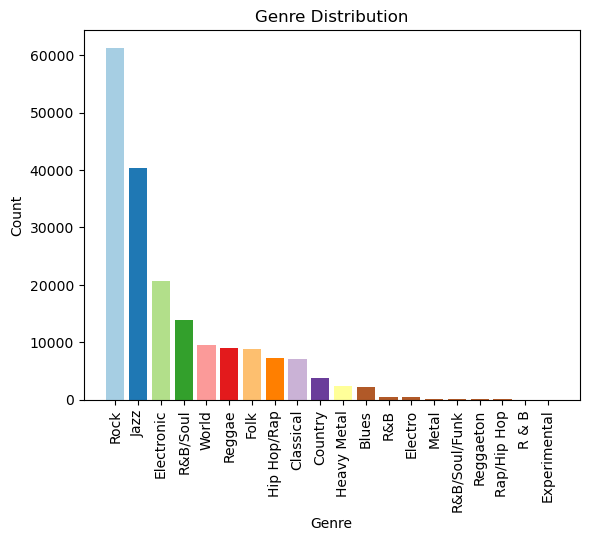

In [8]:
# Visualize genre distribution
genre_counts = df["Genre"].value_counts()
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.bar(genre_counts.index, genre_counts, color=plt.cm.Paired(np.arange(len(genre_counts))))

# TODO: Combine genres


<Axes: >

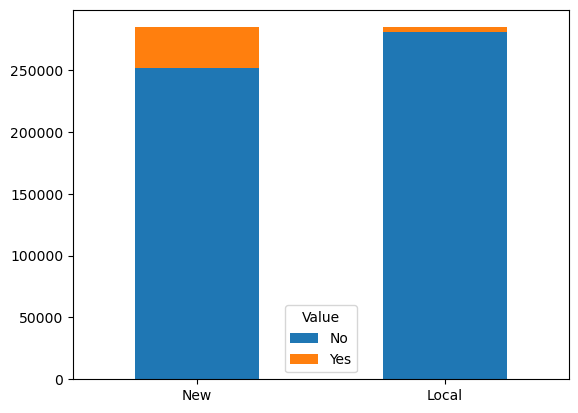

In [9]:
# Visualize local and new distributions
total_spins = df.shape[0]
num_new = df["New"].sum()
num_local = df["Local"].sum()
new_and_local = pd.DataFrame({"New": [total_spins - num_new, num_new],
                              "Local": [total_spins - num_local, num_local],
                              "Value": ["No", "Yes"]}).set_index("Value")
new_and_local.T.plot.bar(stacked=True, rot=0)
    

In [10]:
# Temporary add (for work below), until the feature is properly created via scraping
df["Top100"] = 0

C:\Users\Zachary\AppData\Local\Temp\ipykernel_13716\852859633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Top100"] = 0


In [48]:
def spins_to_dj(spin_df: pd.DataFrame):
    """
    df - a pandas DataFrame of Spinitron spin records
    Returns: a dataframe in dj format
    """
    # Begin a dataframe, where each row is indentified by dj name
    dj_df = spin_df.groupby(["DJ Name"]).count().reset_index()
    dj_df = dj_df[["DJ Name", "Playlist Title"]].rename(columns={"Playlist Title": "num_spins"})

    # Engineered Features: Time of day, duration, average # spins, average spin length

    # Populate genre count features

    # Count new music policy violations
    new_df = spin_df[["DJ Name", "Date", "New"]].groupby(["DJ Name", "Date"]).sum().reset_index()
    one_day_spin_count_df = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
    one_day_spin_count_df = one_day_spin_count_df[["DJ Name", "Date", "Playlist Title"]]
    one_day_spin_count_df = one_day_spin_count_df.rename(columns={"Playlist Title": "show_spins"})
    joined_new_df = pd.merge(new_df, one_day_spin_count_df, on=["DJ Name", "Date"], how='inner')
    joined_new_df["new_percent"] = joined_new_df["New"] / joined_new_df["show_spins"]
    joined_new_df["new_violations"] = (joined_new_df["new_percent"] < 0.25).astype(int)
    grouped_new_df = joined_new_df[["DJ Name", "new_violations"]].groupby("DJ Name").sum().reset_index()
    dj_df = pd.merge(dj_df, grouped_new_df, on="DJ Name", how='inner')

    # Count popular artist policy violations

    # Calculate policy violation feature

    return dj_df

df1 = spins_to_dj(spin_df=df)
df1

            DJ Name  new_violations
0      Adam Higgins               3
1         Agent One              12
2             Ava P              50
3         B. Stokes              19
4         Babytooth               6
..              ...             ...
237          lizard              33
238        old greg               1
239  otis cleveland             150
240             syd               4
241            vron              11

[242 rows x 2 columns]


,DJ Name,num_spins,new_violations
0,Adam Higgins,1270,3
1,Agent One,402,12
2,Ava P,1676,50
3,B. Stokes,621,19
4,Babytooth,321,6
...,...,...,...
237,lizard,640,33
238,old greg,14,1
239,otis cleveland,3866,150
240,syd,269,4


## Data Modeling

#### Policy Violation Linear Regression

#### DJ Clustering